In [1]:
import sys
sys.path.append("../../")

from astronn.preprocess import predeltascuti, precorot
from astronn.datasets import deltascuti, starmodels, corot
from astronn import models

import tensorflow as tf

import numpy as np
import shap

import matplotlib.pyplot as plt
from pygam import LinearGAM
from collections import Counter

Using TensorFlow backend.


#### Preprocess is not needed if data exists in beforehand

In [2]:
# Preprocess eleven delta scuti stars
if False:
    # Preprocess DS stars
    preprocessor = predeltascuti()
    preprocessor.preprocess_files(
        input_folder="../../astronn/data/deltascuti/raw/*",
        output_folder="../../astronn/data/deltascuti/preprocessed/",
    )

# Preprocess 77 CoRoT stars
if False:
    preprocessor = precorot(conf_file="../../astronn/data/corot/parameters.csv", cols=["corot", "loggs"])
    preprocessor.preprocess_files(
        input_folder="../../astronn/data/corot/raw/*",
        output_folder="../../astronn/data/corot/preprocessed/",
    )

#### Utils functions

In [3]:
def normalize(x):
    """
    """
    return (x - np.min(x)) / (np.max(x) - np.min(x))

# Custom metrics
def top_2_categorical_accuracy(y_true, y_pred):
    return tf.keras.metrics.top_k_categorical_accuracy(y_true, y_pred, k=2)

def top_4_categorical_accuracy(y_true, y_pred):
    return tf.keras.metrics.top_k_categorical_accuracy(y_true, y_pred, k=4)

def top_6_categorical_accuracy(y_true, y_pred):
    return tf.keras.metrics.top_k_categorical_accuracy(y_true, y_pred, k=6)

def top_8_categorical_accuracy(y_true, y_pred):
    return tf.keras.metrics.top_k_categorical_accuracy(y_true, y_pred, k=8)

def calculate_shap_by_gradient(model, x_explain):
    """
    """
    e = shap.GradientExplainer(model, x_train, batch_size=1000, local_smoothing=0)
    shap_values, indexes = e.shap_values(x_explain, nsamples=10000, ranked_outputs=5)
    return shap_values, indexes

In [4]:
# Load best model (old train method)
sepconv_mod = tf.keras.models.load_model(
    "/home/roberto/Projects/asteroseismologyNN/models/model_dnu_noisy.h5",
    custom_objects={"rec_at_2": top_2_categorical_accuracy,
                    "rec_at_4": top_4_categorical_accuracy,
                    "recat_6": top_6_categorical_accuracy,
                    "rec_at_8": top_8_categorical_accuracy}
)

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


#### Process 11 ds stars, infer Dnu and calculate shap values explanations

[[52 51 49 50 48 54 53 47 55 56]]
[[36 34 37 35 33 38 39 32 31 40]]
[[26 25 27 24 23 22 21 29 28 20]]
[[38 22 37 40 41 31 28 29 36 27]]
[[36 37 35 34 38 33 39 32 20 23]]
[[54 53 52 51 55 50 62 56 63 49]]
[[50 75 49 61 51 48 43 87 58 85]]
[[31 34 32 30 33 29 28 27 36 41]]
[[39 40 38 41 37 36 26 35 54 55]]
[[26 54 53 25 21 20 27 55 38 28]]
[[34 36 37 33 35 26 22 23 38 31]]


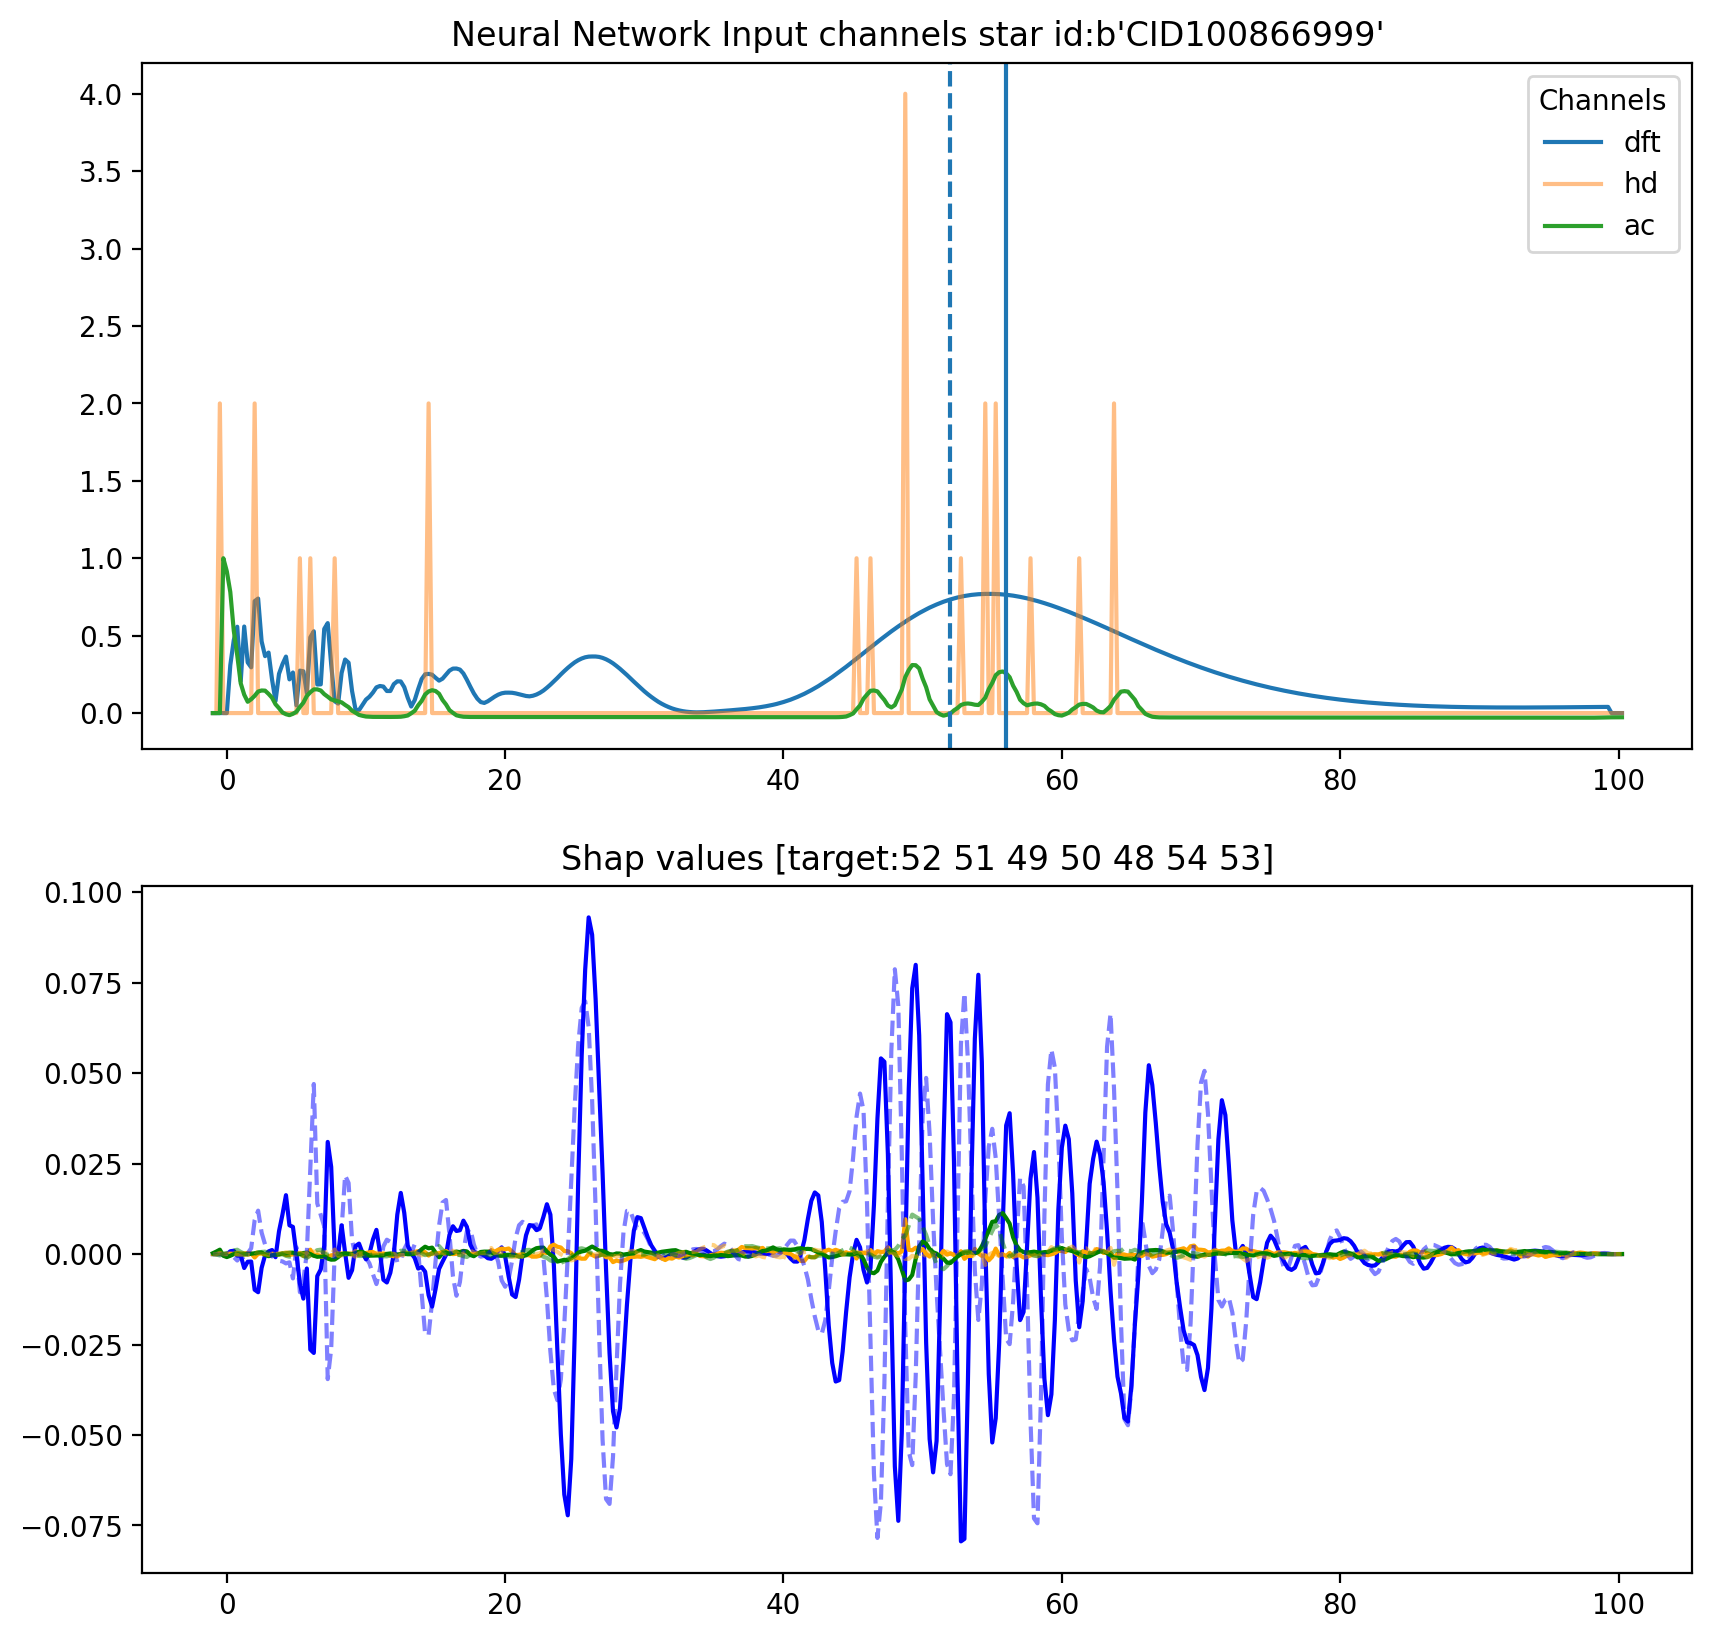

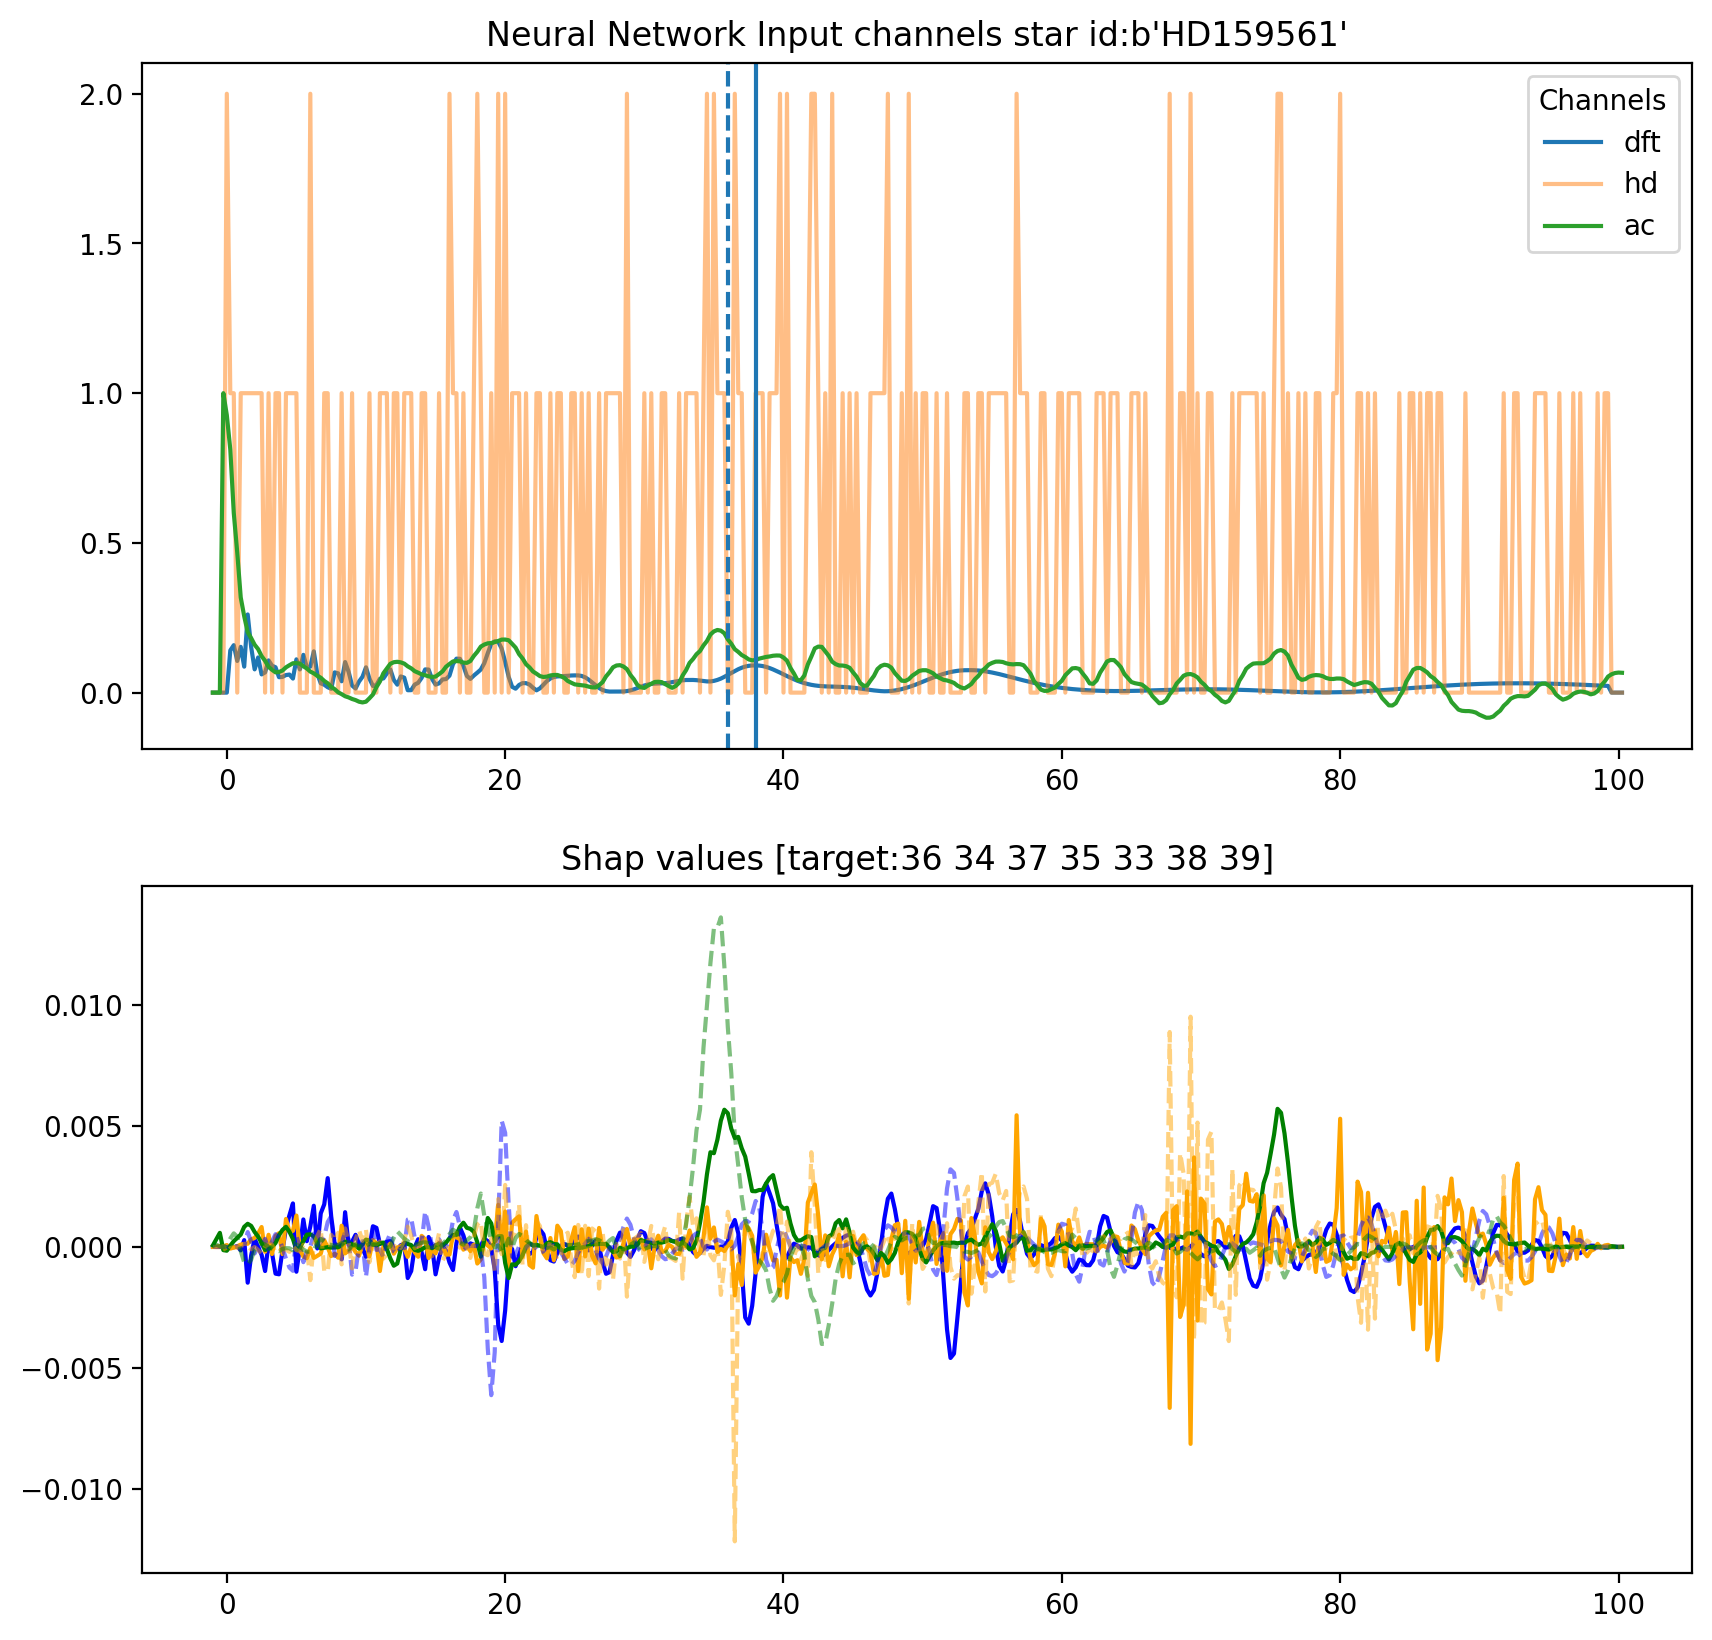

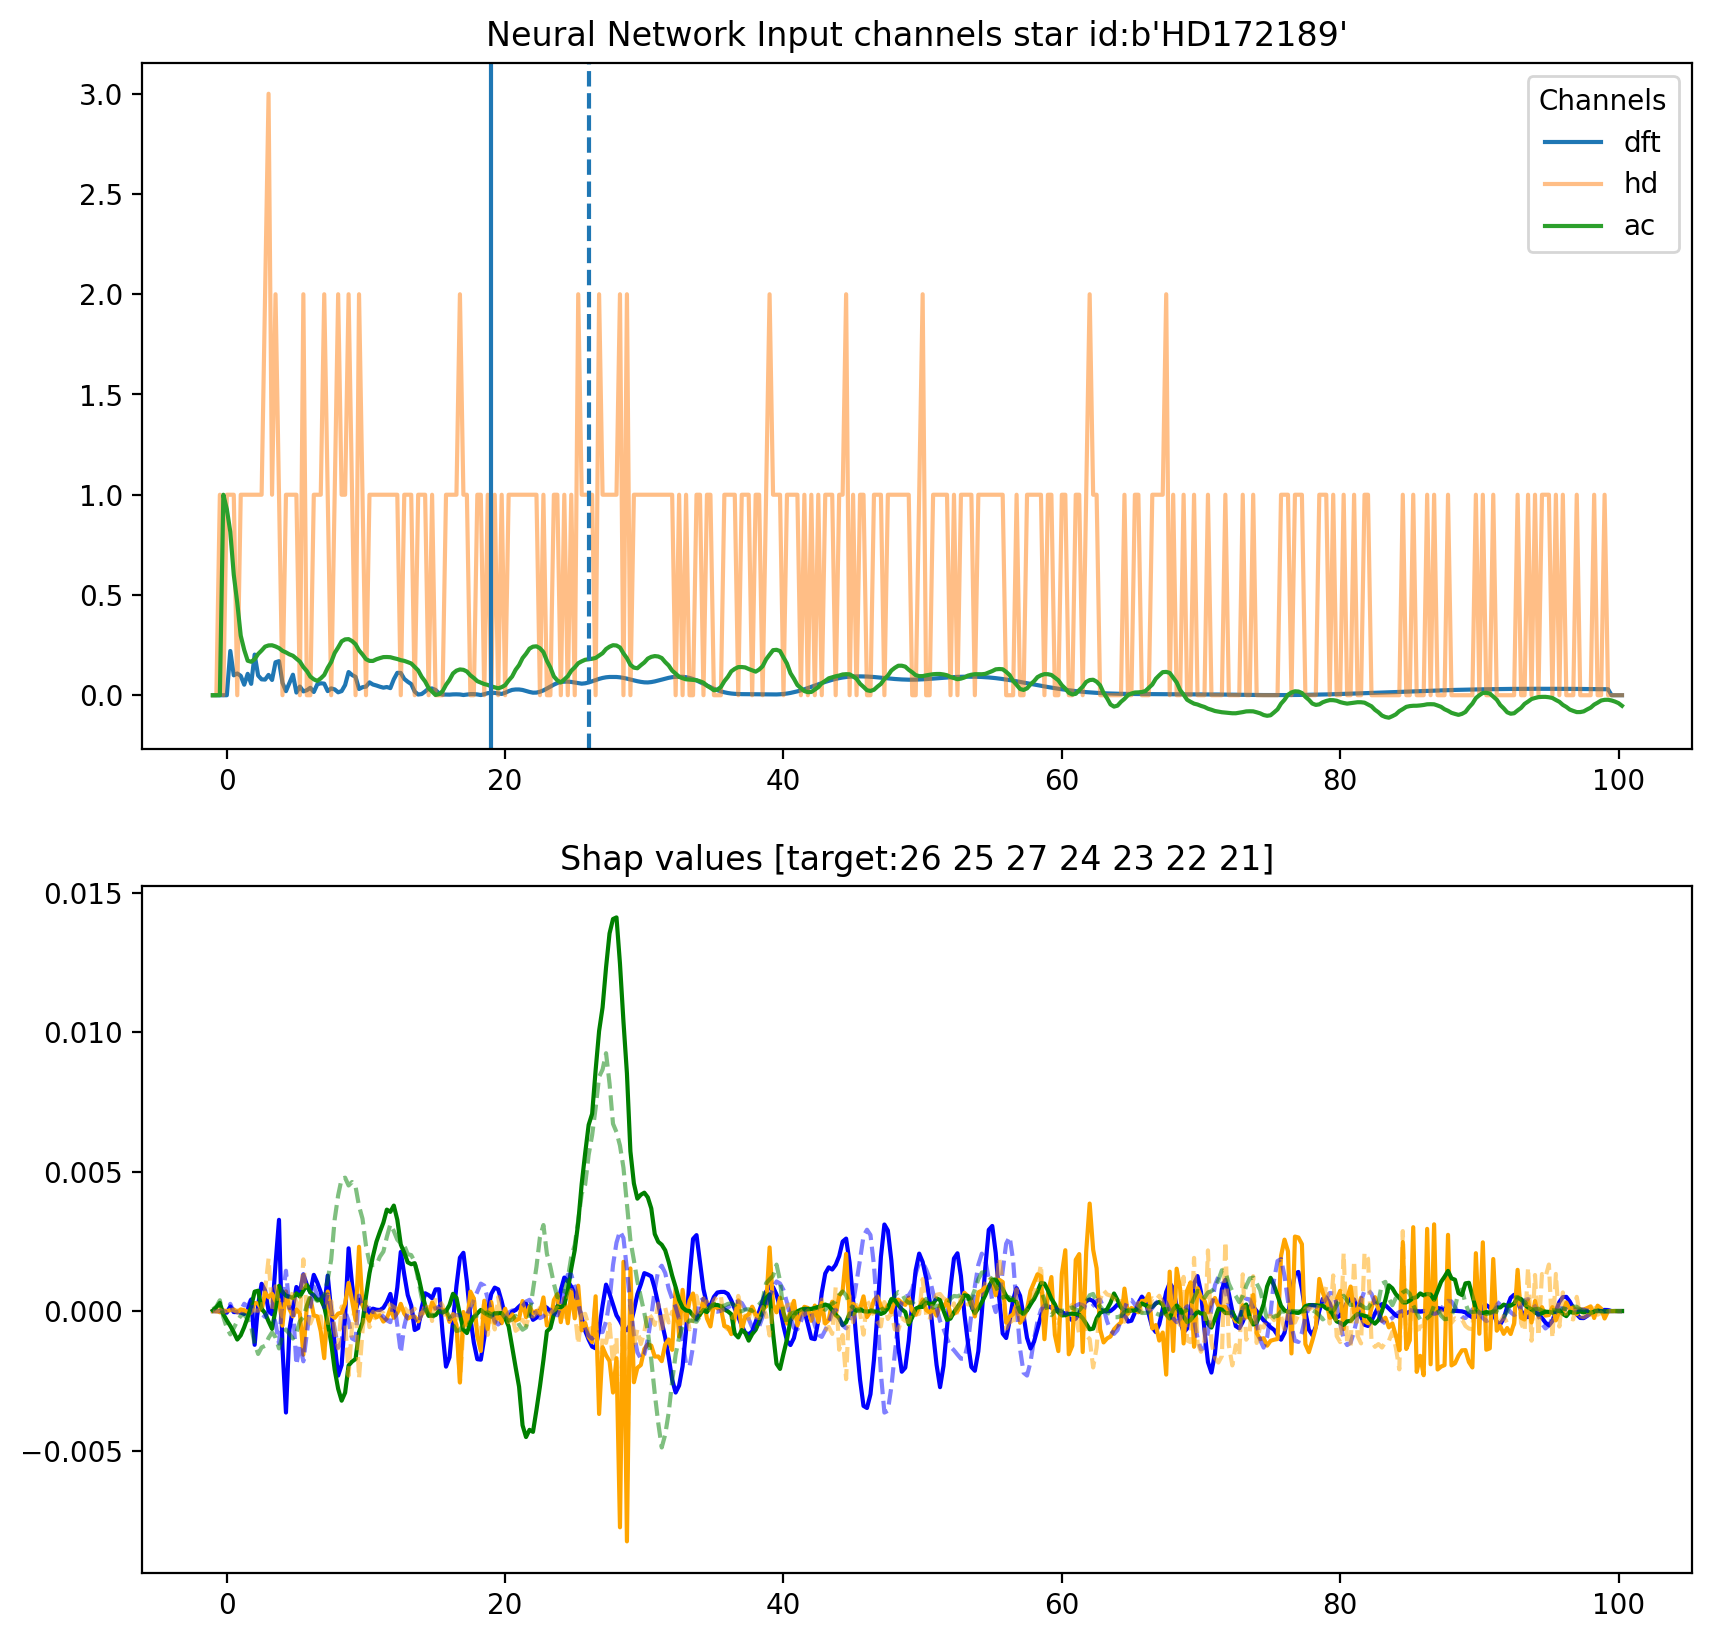

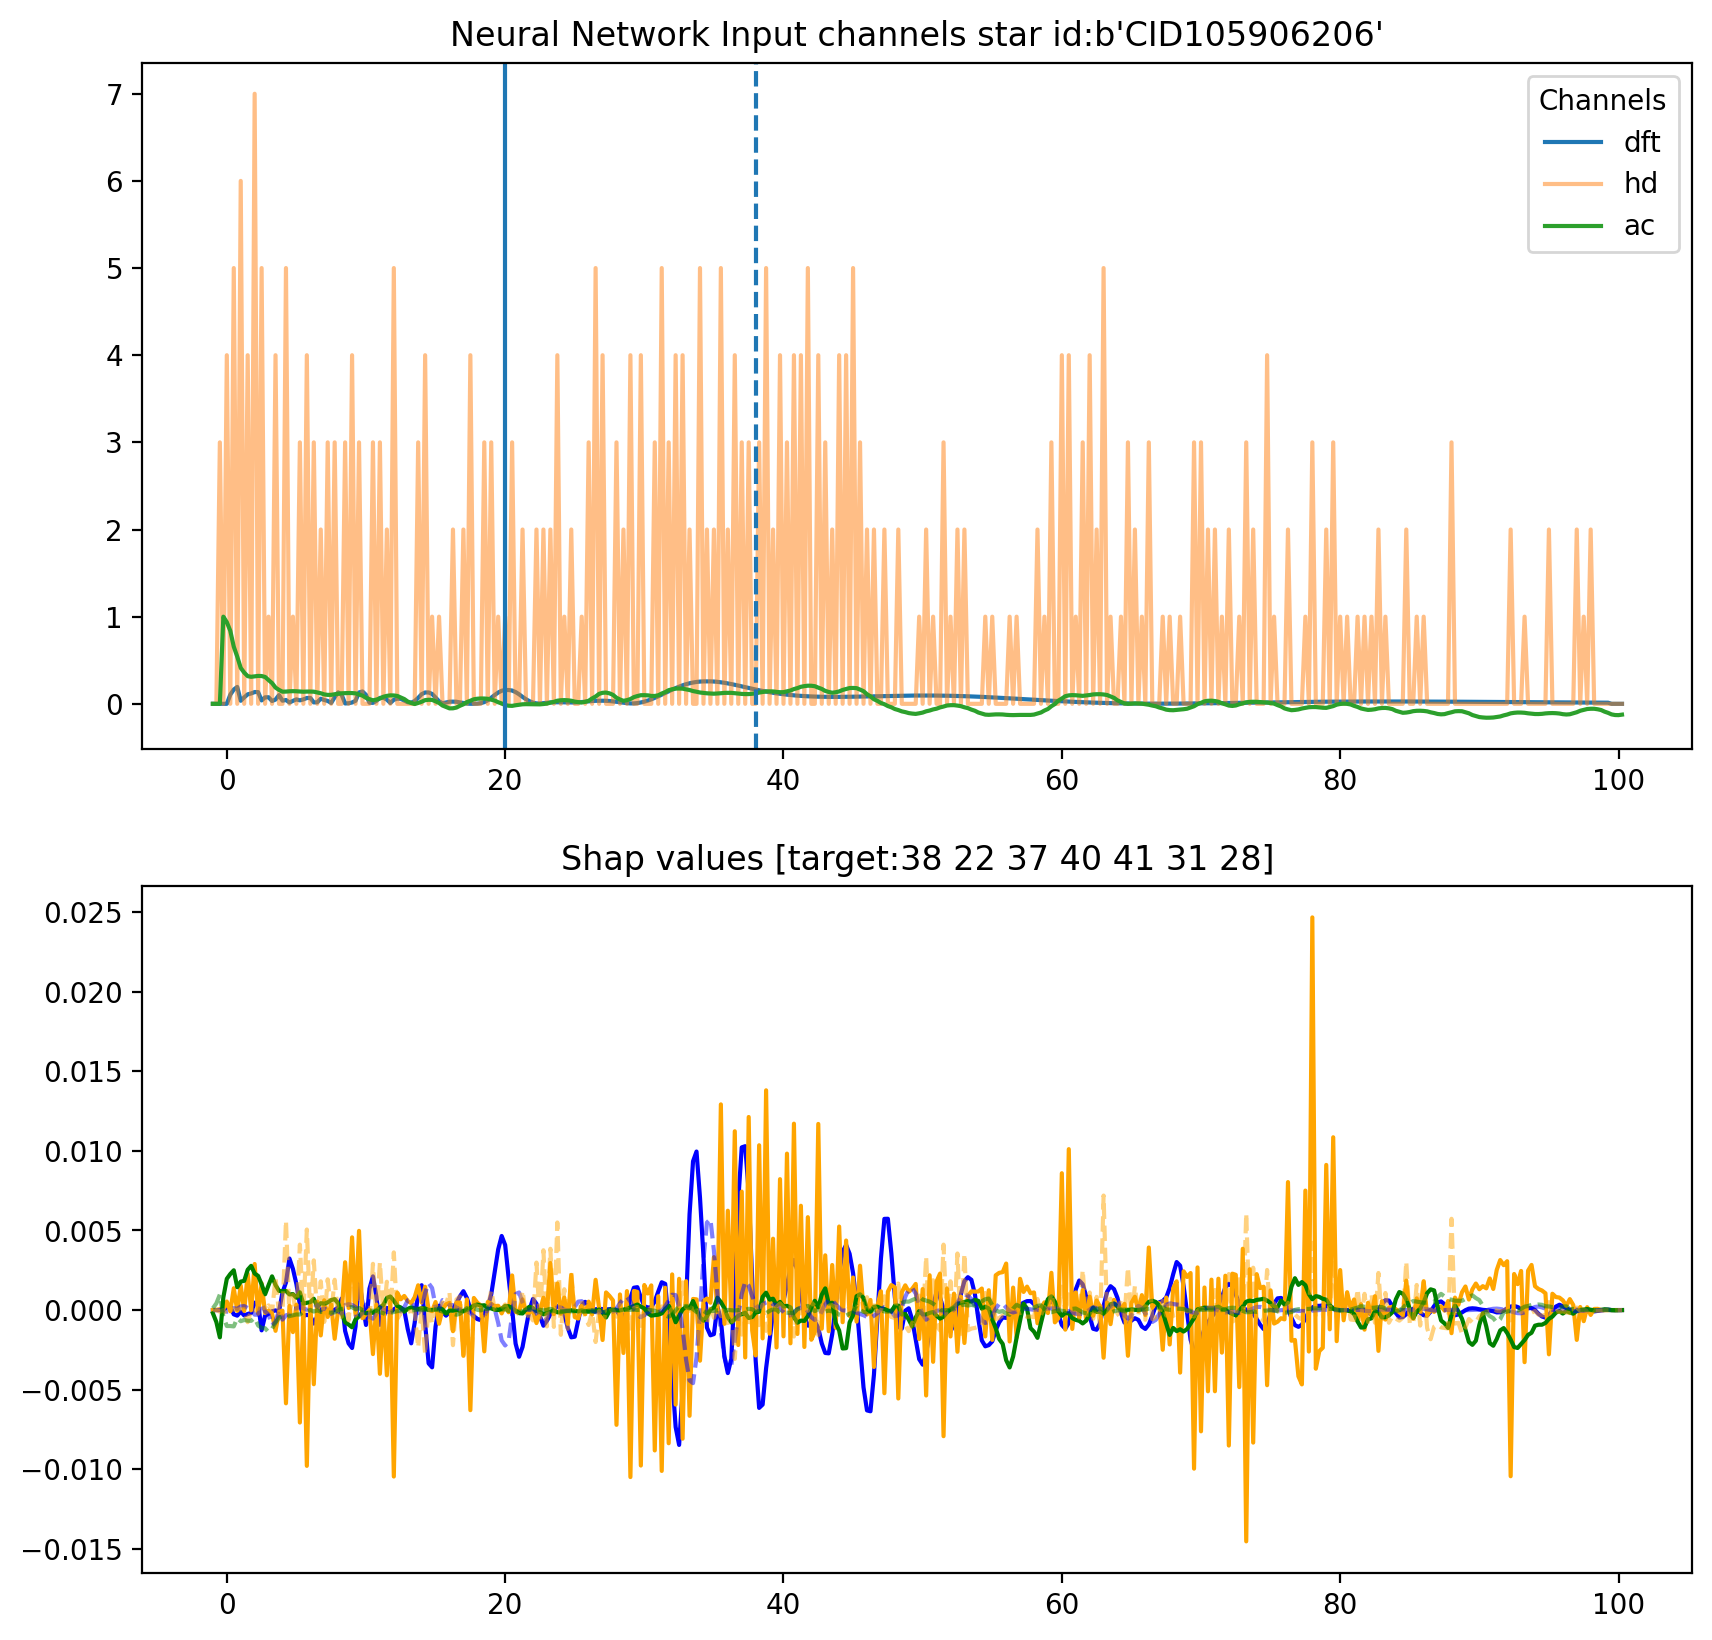

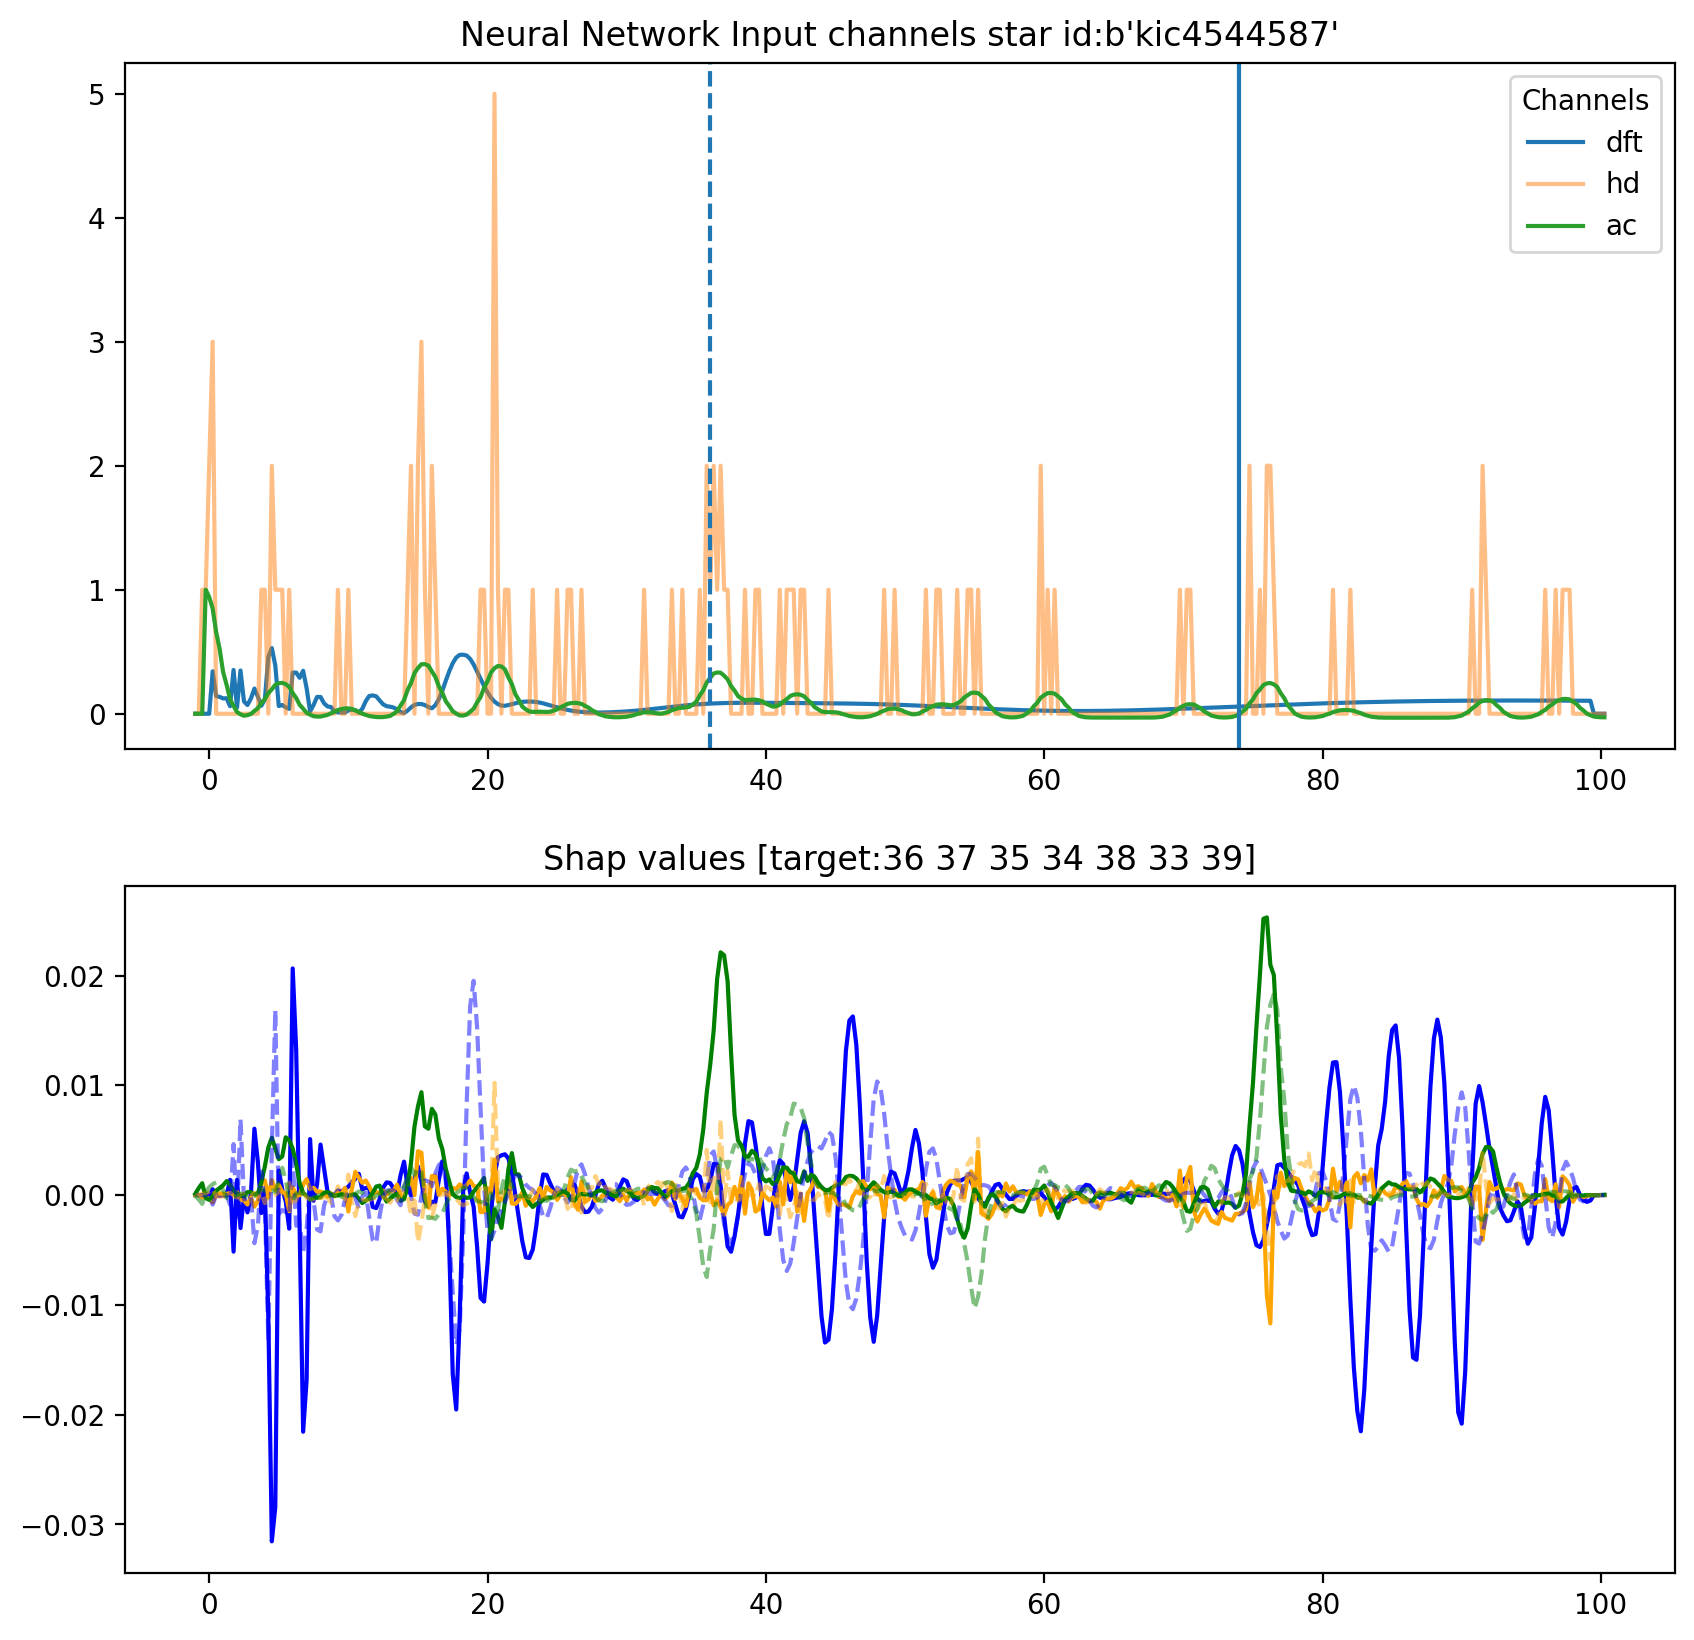

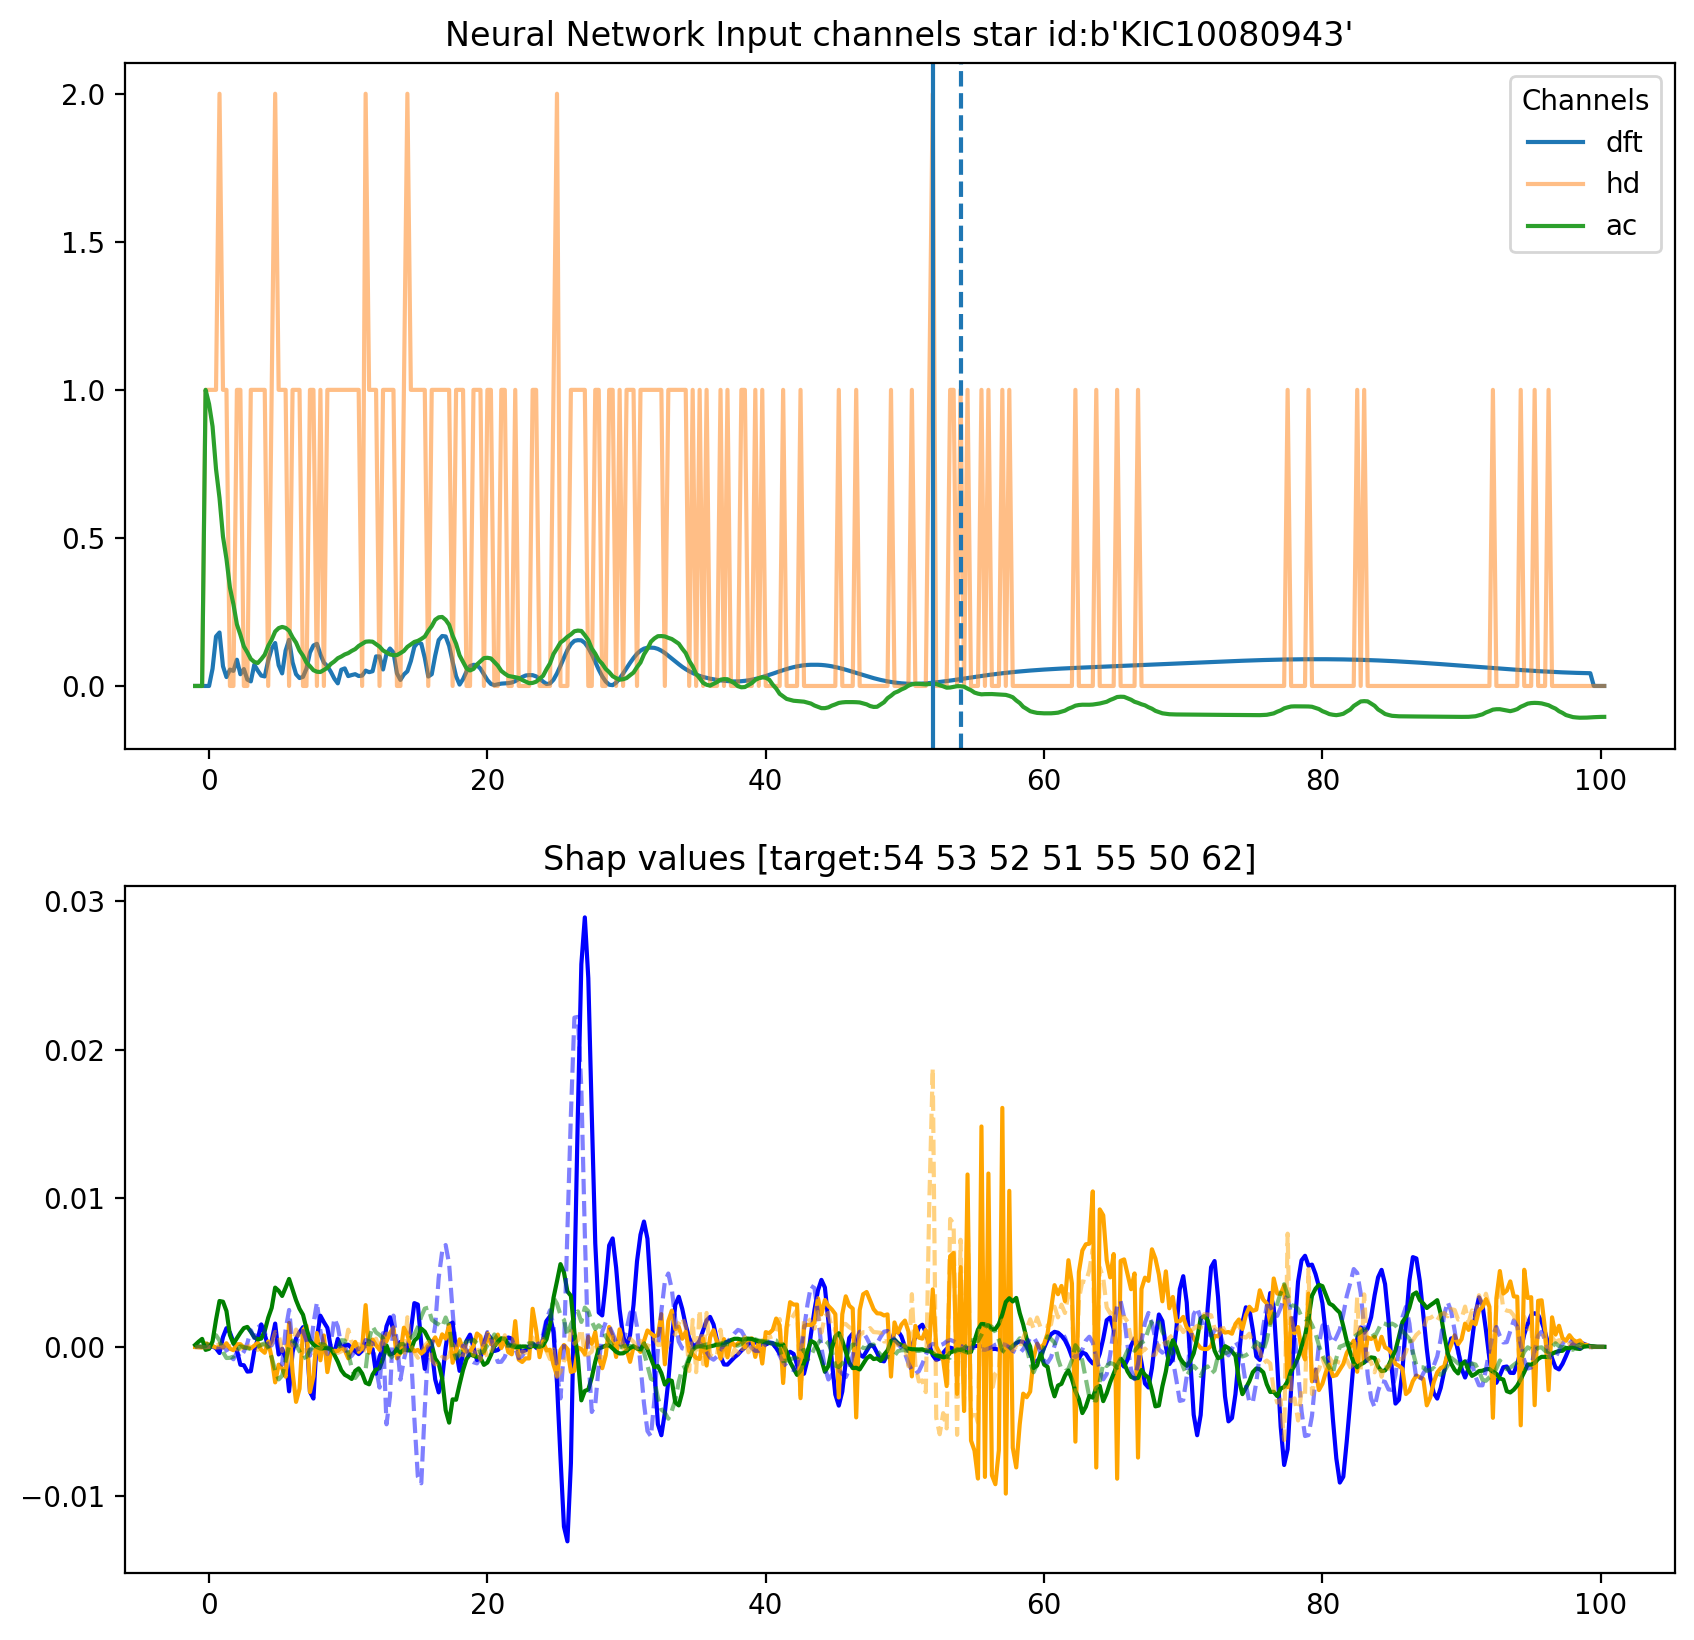

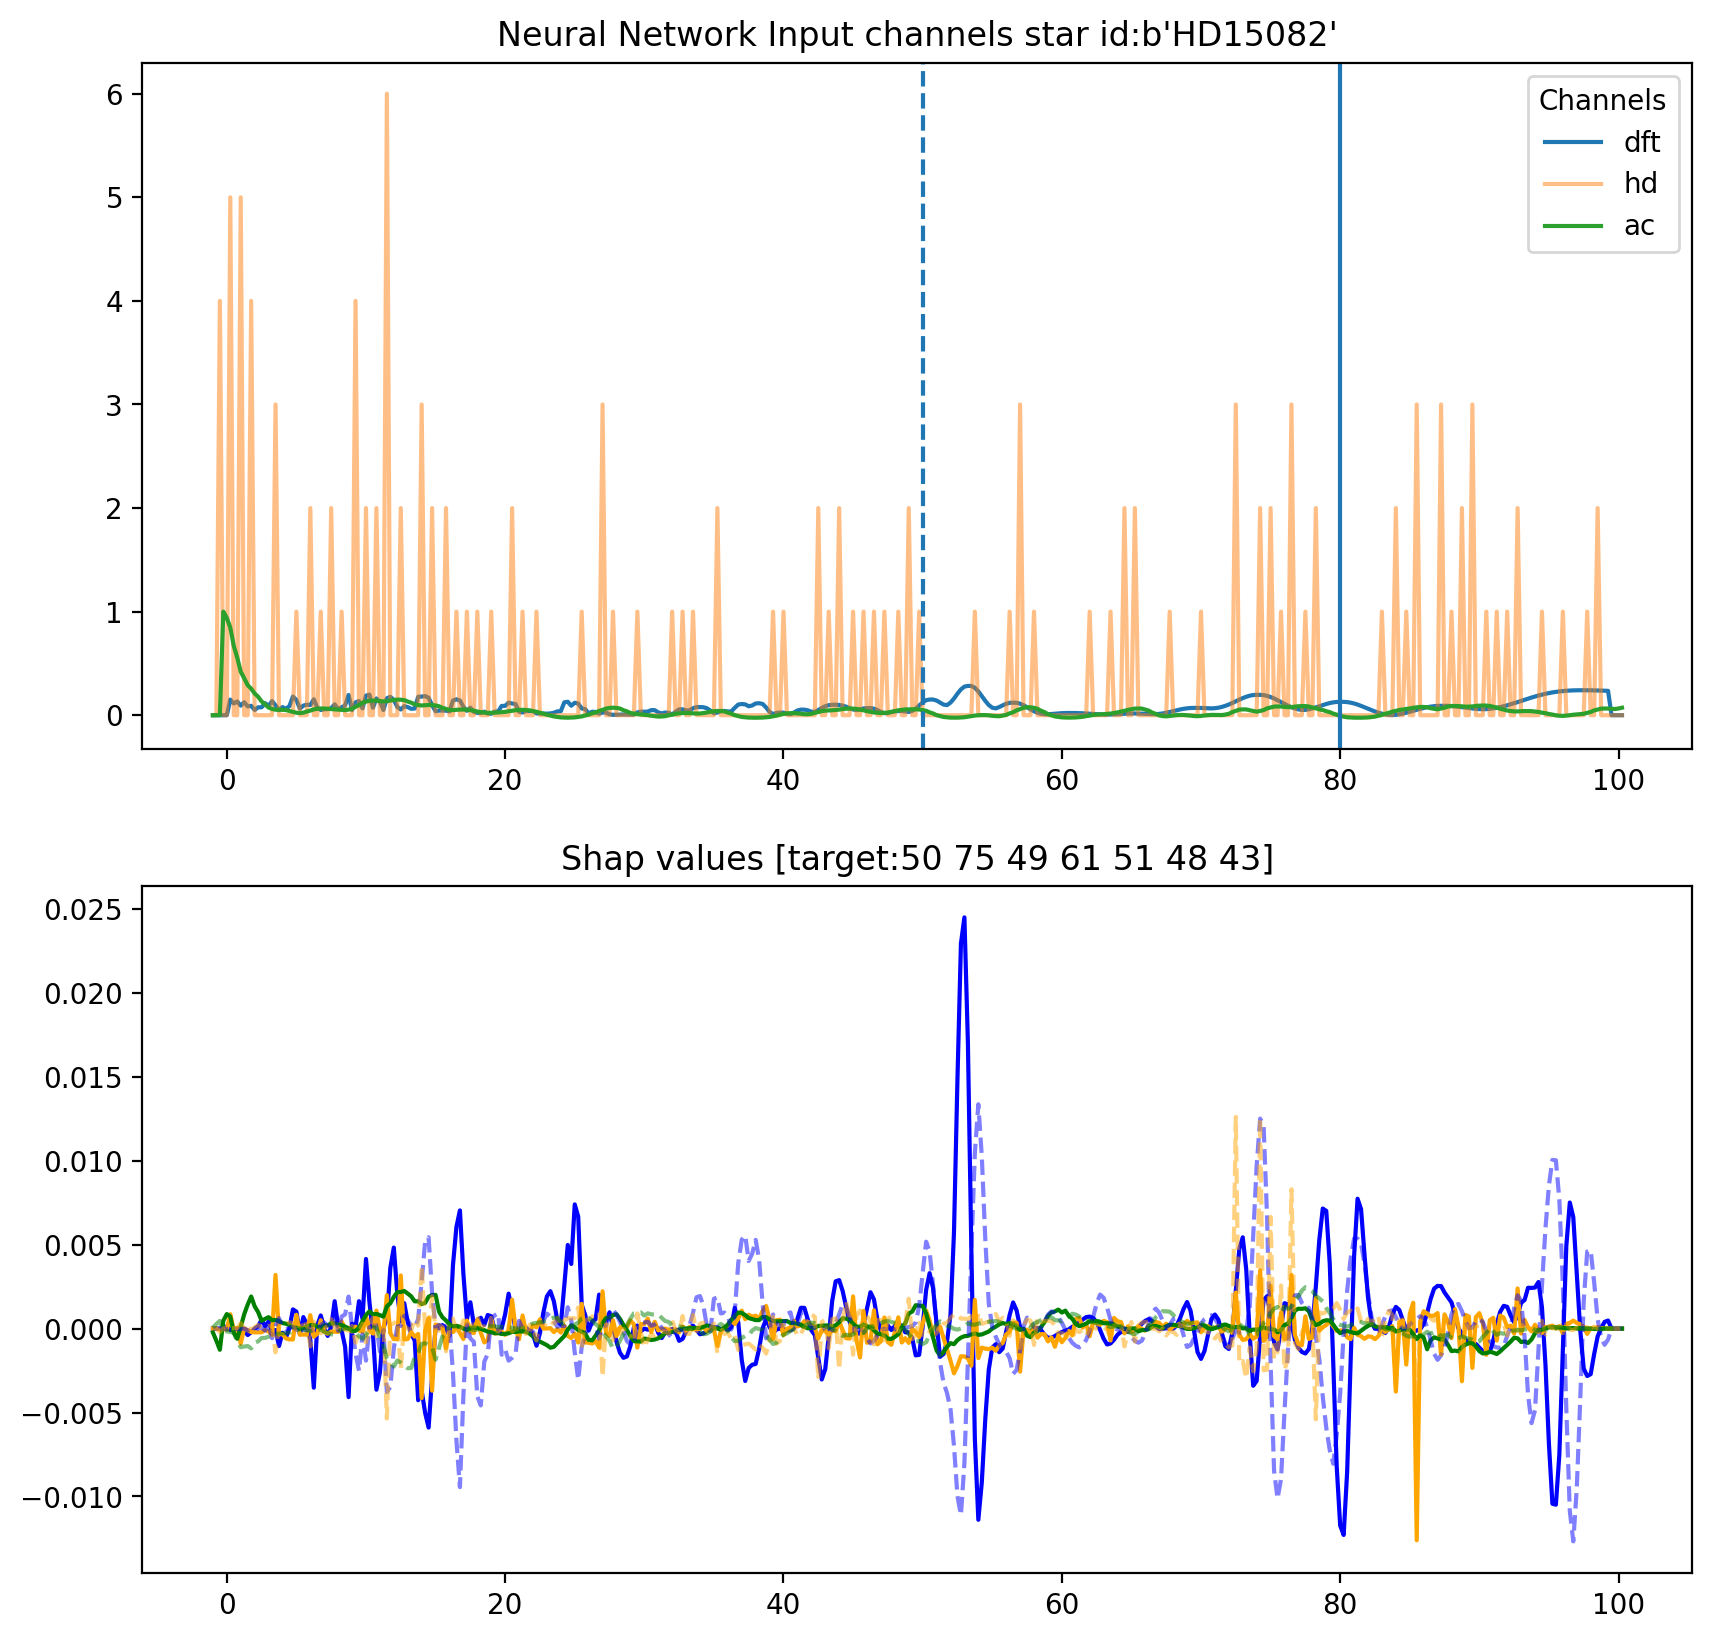

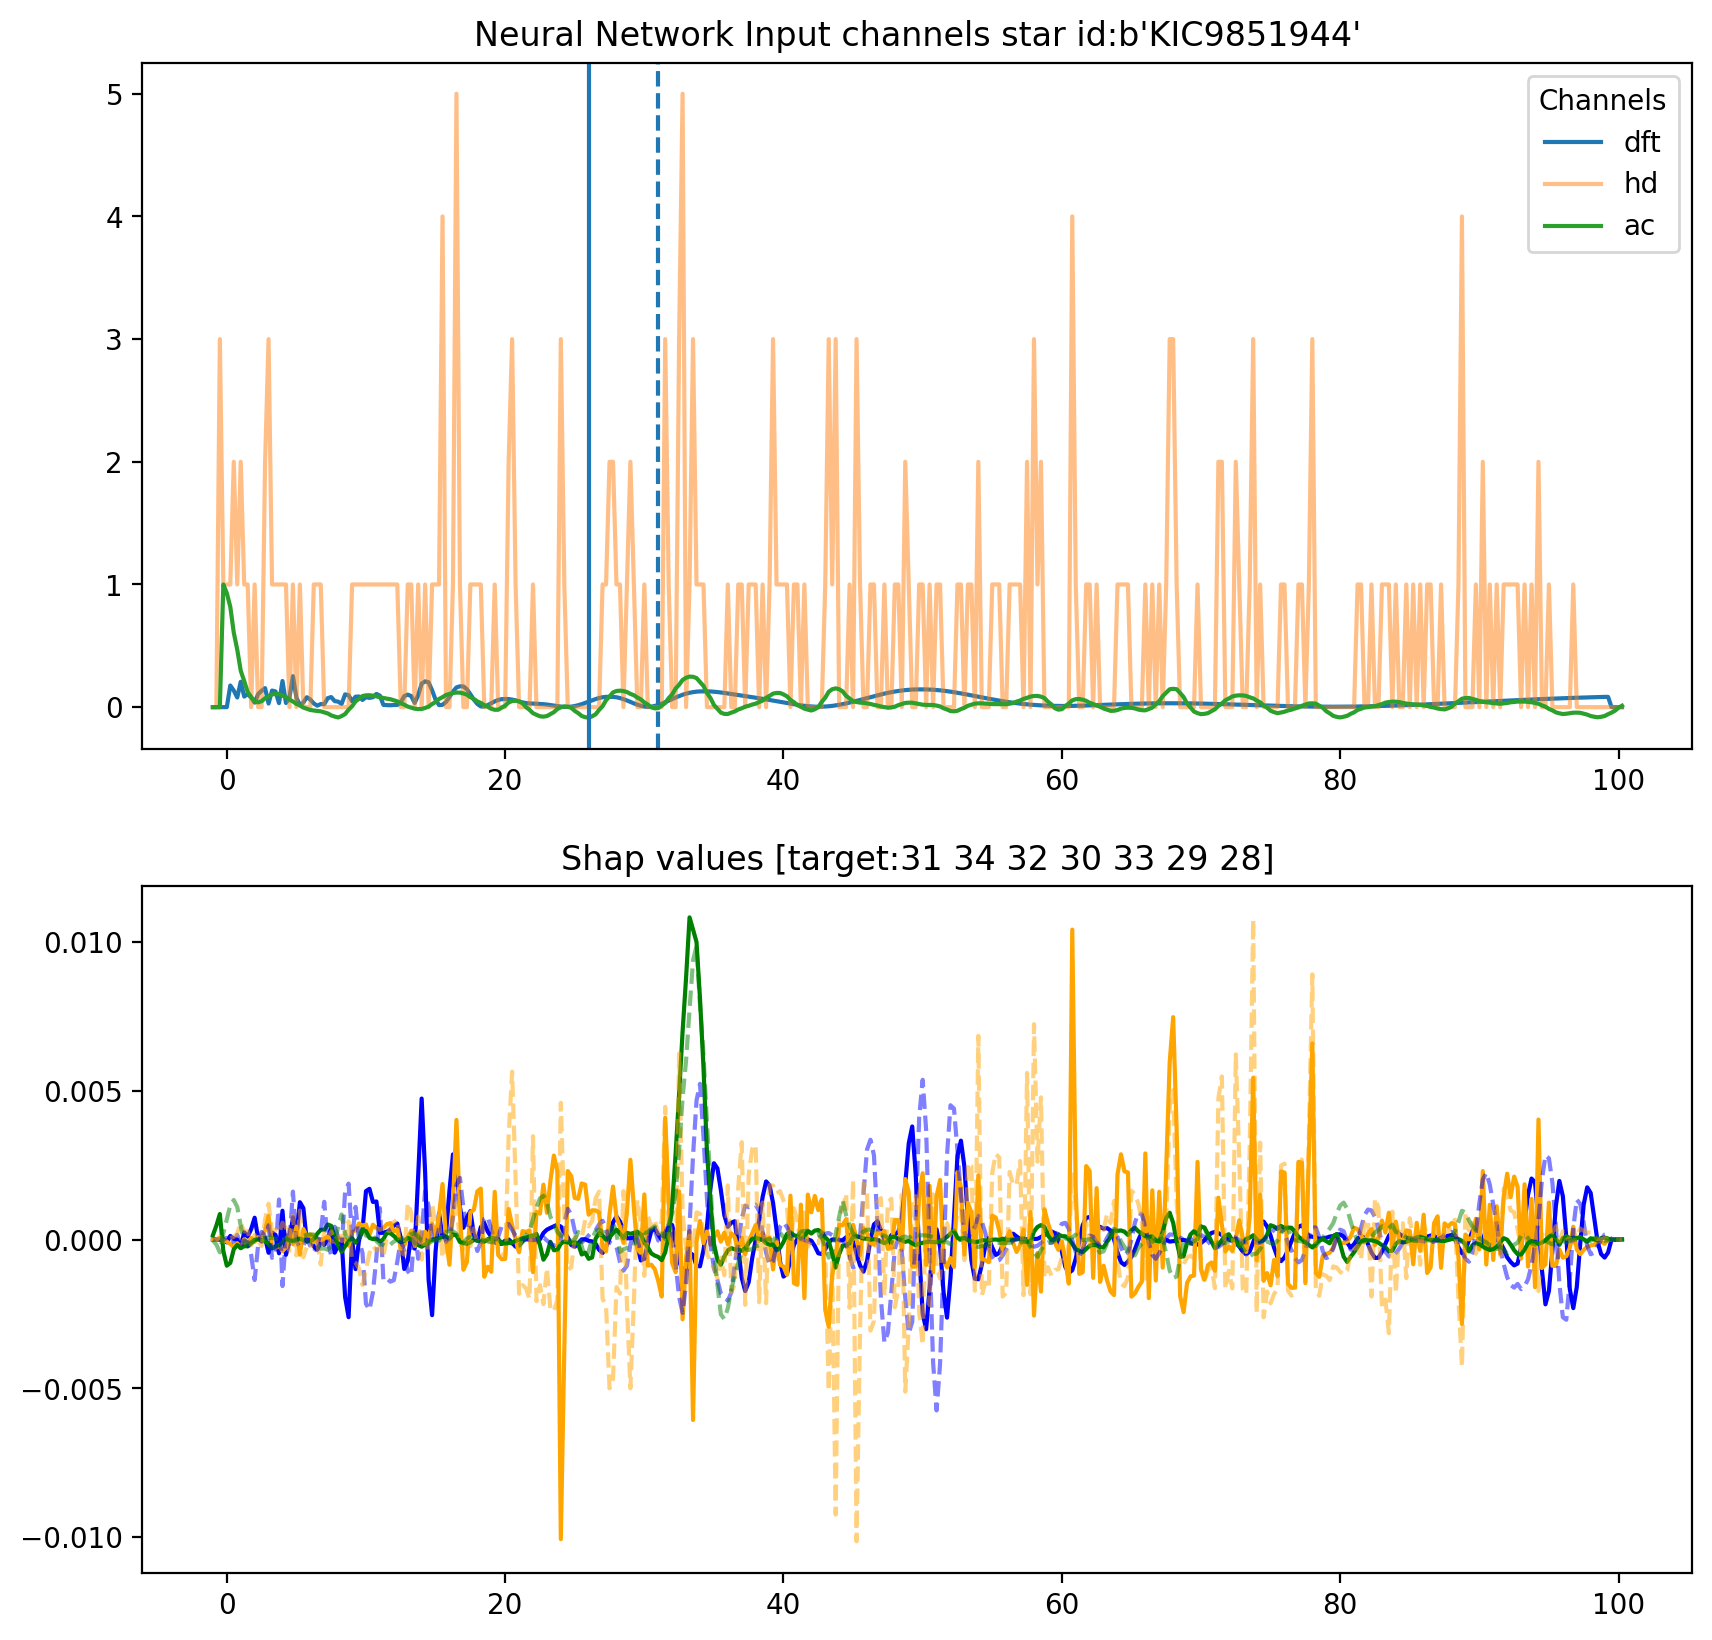

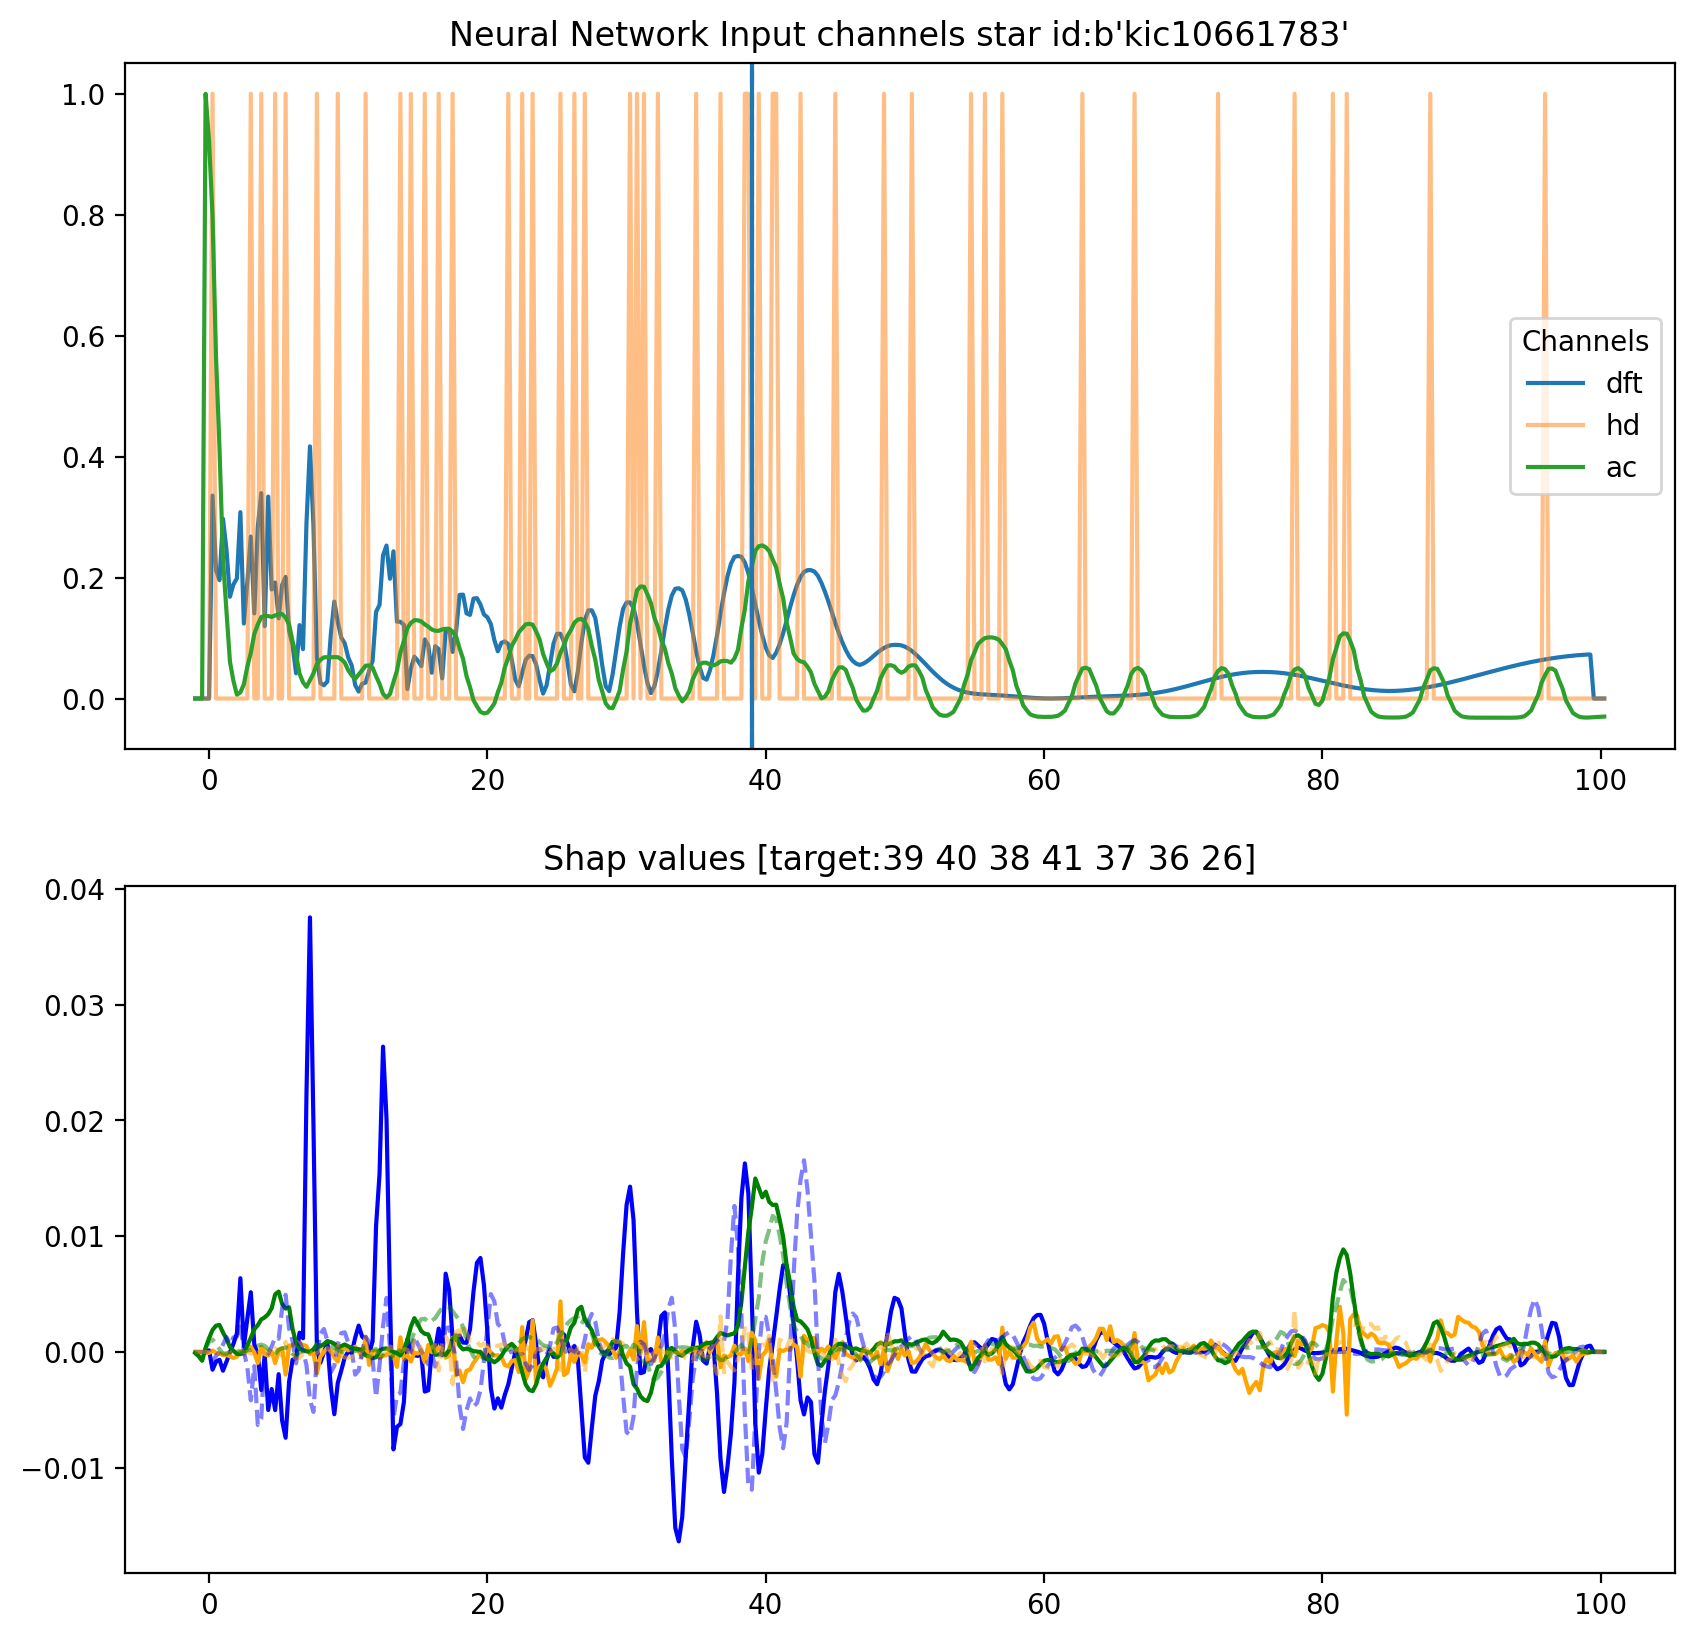

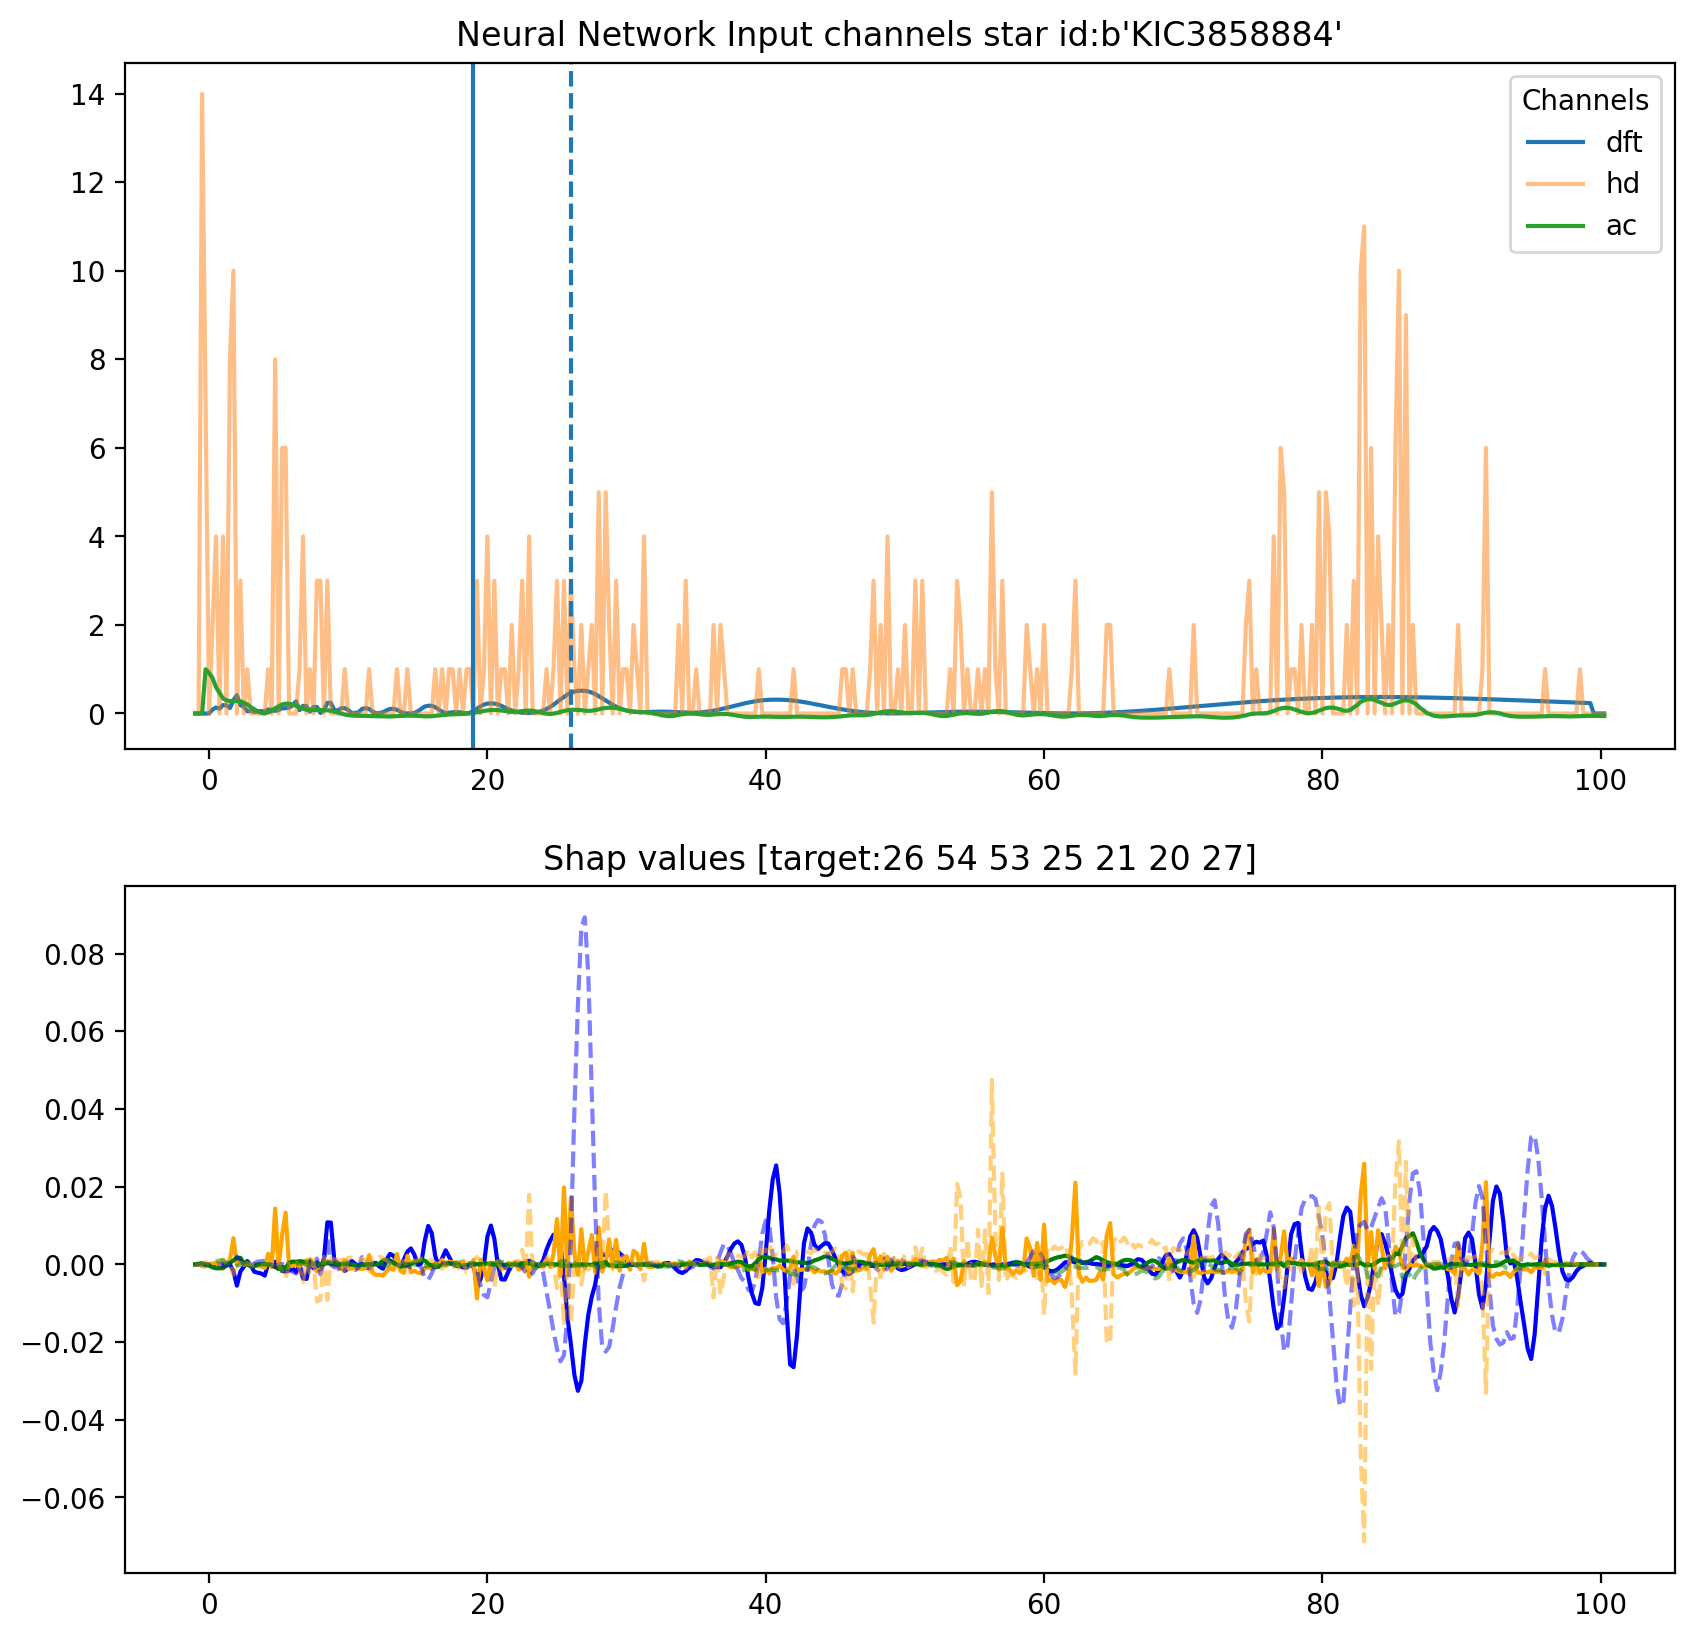

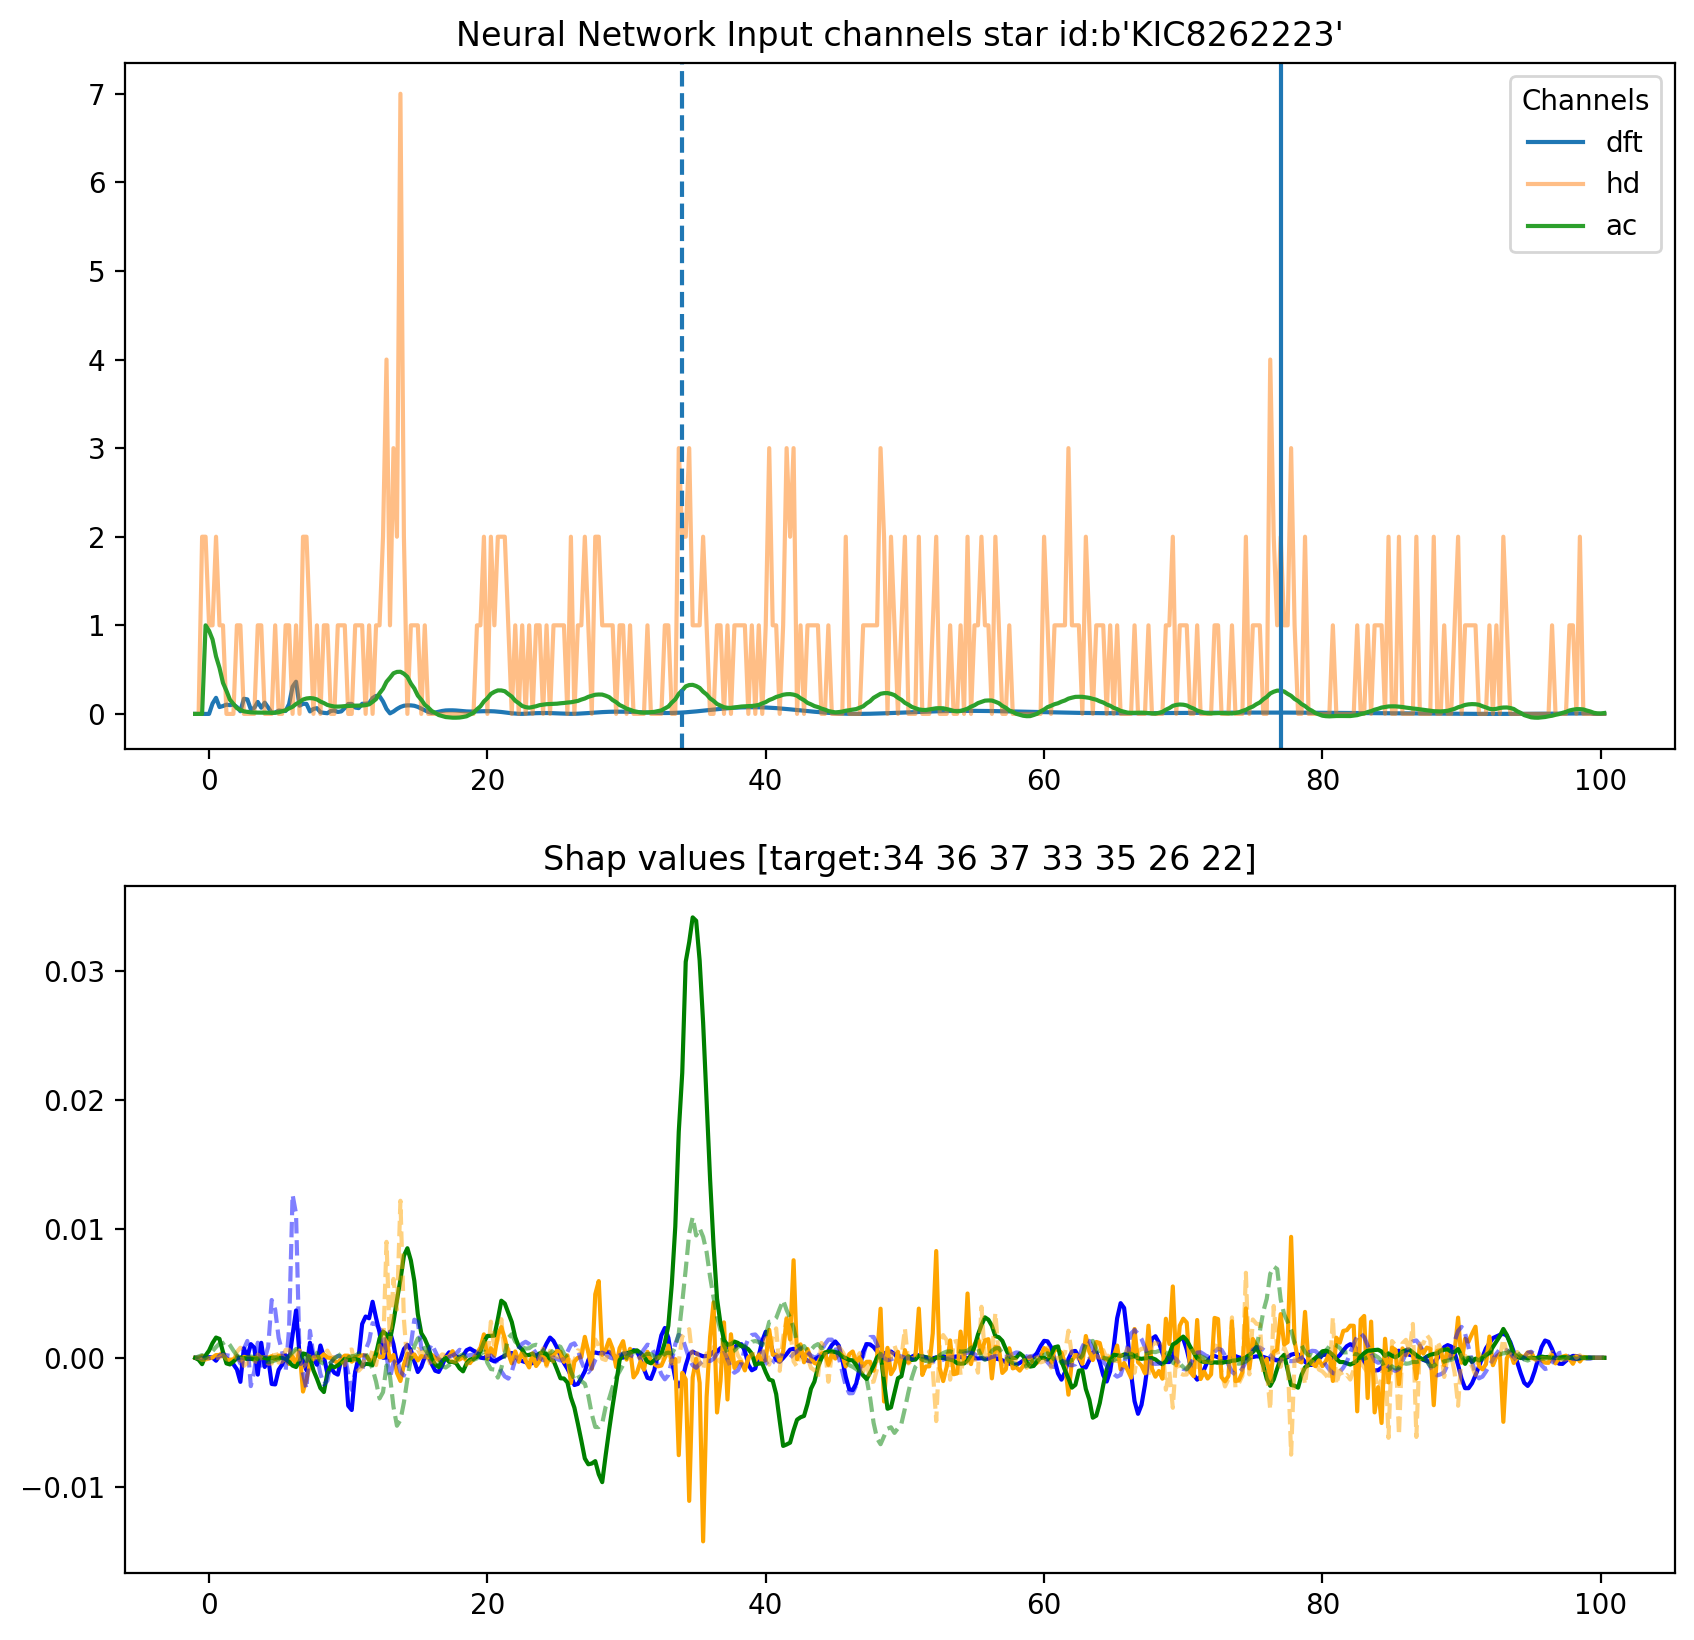

In [5]:
# Read datasets of preprocessed stars
df_ds = deltascuti()
df = df_ds.load("../../astronn/data/deltascuti/preprocessed/*", batch_size=1)
# Read star models (trainning) to calculate shap values
star_models = starmodels()
df_sm = star_models.load("/home/roberto/Downloads/dataall_parts/*", batch_size=150)
_train_shap = np.asarray([line[0].numpy() for line in df_sm.take(10)])
_train_shap = _train_shap.reshape(
    (
        _train_shap.shape[0] * _train_shap.shape[1],
        _train_shap.shape[2],
        _train_shap.shape[3],
    )
)
# Load model
sepconv_mod = tf.keras.models.load_model("/tmp/sepconvnn_tmp_99")

x = np.arange(-1, 100.5, 0.25)  # x axis from 0 to 100

for star in df.take(11):  # take the 11 ds stars
    target = np.where(star[2].numpy().flat == 1)[0].flat[0]
    # Plot information about ds star
    fig, (ax1, ax2) = plt.subplots(2, figsize=(10, 10), dpi=200)
    ax1.plot(x, star[1][0, :, 0].numpy(), label="dft")
    ax1.plot(x, star[1][0, :, 1].numpy(), alpha=0.5, label="hd")
    ax1.plot(x, star[1][0, :, 2].numpy(), label="ac")
    target = np.where(star[2].numpy().flat == 1)[0].flat[0]
    ax1.axvline(x=target)
    ax1.axvline(x=sepconv_mod.predict_classes(star[1]), linestyle="--")
    # Calculate gradient explainers and shap values
    e = shap.GradientExplainer(
        sepconv_mod, _train_shap, batch_size=10, local_smoothing=0
    )
    shap_values, indexes = e.shap_values(
        star[1].numpy(), nsamples=100, ranked_outputs=10
    )
    print(indexes)
    # Plot shap
    ax2.plot(x, shap_values[0][0][:, [0]], label="dft", linestyle="solid", color="blue")
    ax2.plot(
        x, shap_values[0][0][:, [1]], label="hd", linestyle="solid", color="orange"
    )
    ax2.plot(x, shap_values[0][0][:, [2]], label="ac", linestyle="solid", color="green")
    ax2.plot(
        x,
        shap_values[1][0][:, [0]],
        label="dft",
        linestyle="--",
        color="blue",
        alpha=0.5,
    )
    ax2.plot(
        x,
        shap_values[1][0][:, [1]],
        label="hd",
        linestyle="--",
        color="orange",
        alpha=0.5,
    )
    ax2.plot(
        x,
        shap_values[1][0][:, [2]],
        label="ac",
        linestyle="--",
        color="green",
        alpha=0.5,
    )

    ax1.legend(title="Channels")
    ax1.title.set_text("Neural Network Input channels" + " star id:" + str(star[0].numpy()[0]))
    ax2.title.set_text(
        "Shap values"
        + " [target:"
        + str(indexes[0][0])
        + " "
        + str(indexes[0][1])
        + " "
        + str(indexes[0][2])
        + " "
        + str(indexes[0][3])
        + " "
        + str(indexes[0][4])
        + " "
        + str(indexes[0][5])
        + " "
        + str(indexes[0][6])
        + "]"
    )
    fig.show()

In [6]:
cid = None
for star in df.take(11):  # take the 11 ds stars
    print(str(star[0].numpy()[0]))
    if star[0].numpy()[0].decode("utf-8") == 'CID100866999':
        cid = star

b'KIC8262223'
b'kic10661783'
b'kic4544587'
b'KIC3858884'
b'KIC9851944'
b'CID100866999'
b'KIC10080943'
b'HD15082'
b'HD159561'
b'HD172189'
b'CID105906206'


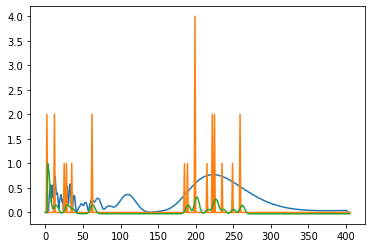

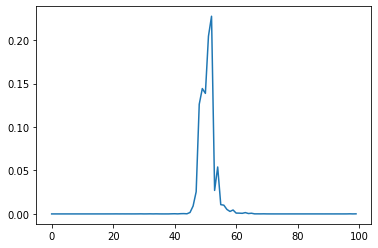

In [7]:
# Plot sample star
x = cid[1].numpy()

# Modify values
#x[0, 0:400, 0] = 0.5

plt.plot(x[0, :, 0])
plt.plot(x[0, :, 1])
plt.plot(x[0, :, 2])
plt.show()
plt.plot(sepconv_mod.predict_proba(x)[0][0:100])
plt.show()

## CoRoT 75 stars study

In [8]:
vrrhosun = 1.409
vrloggsun = 4.44


def getRhoFromDnu(Dnu, e_Dnu=0):
    """
    calculate Rho from Dnu estimating the error produced
    """
    rho_sun = 1.409
    dnu_sun = 134.8
    a = 1.501
    e_a = 0.096
    b = 2.0373
    e_b = 0.0405
    rho = (a * (Dnu / dnu_sun) ** b) * rho_sun
    e_rho = rho * np.sqrt(
        (e_a / a) ** 2
        + (b * e_Dnu / (Dnu * dnu_sun)) ** 2
        + (np.log10(Dnu / dnu_sun) * e_b) ** 2
    )
    return {"rho": rho, "error": e_rho}


def get_radio_from_rho(rho, e_rho):
    """
    calculate radio from rho, estimating max and min values
    """
    R_min = (1.5 / (rho + e_rho) / vrrhosun) ** (1 / 3)
    R_max = (3 / (rho - e_rho) / vrrhosun) ** (1 / 3)
    return {"r_min": R_min, "r_max": R_max}


def get_logg_from_radio(R_max, R_min):
    """
    calculate logg from radio estimating max and min values
    """
    logg_min = np.log10(1.5 / R_max ** 2) + vrloggsun
    logg_max = np.log10(3 / R_min ** 2) + vrloggsun
    return {"logg_min": logg_min, "logg_max": logg_max}

# Test
rhos = getRhoFromDnu(21, 4)
radios = get_radio_from_rho(rhos["rho"], rhos["error"])
loggs_condifence = get_logg_from_radio(radios["r_max"], radios["r_min"])
loggs_average = (loggs_condifence["logg_max"] + loggs_condifence["logg_min"]) / 2
loggs_average

3.767547179252057

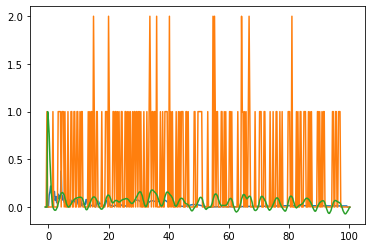

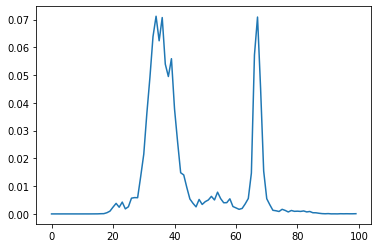

CoRoT ID: 102639650
Shap values (sorted): [[34 67 36 33 35 66 39 37 38 32]]
Logg from Hareter: [3.9]
Avg logg from NN: [4.05183454]
Confidence logg from NN: {'logg_min': array([3.7811369]), 'logg_max': array([4.32253217])}
Logg from Hareter is inside NN confidence=: [ True]


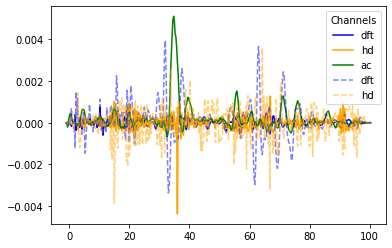

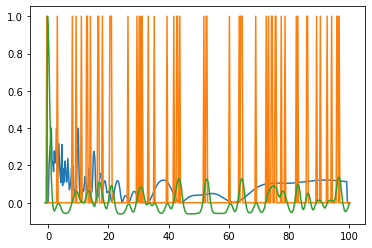

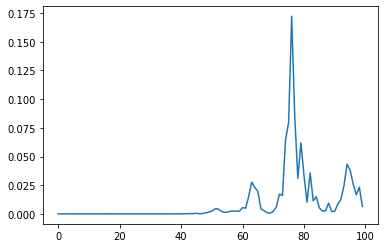

CoRoT ID: 102655408
Shap values (sorted): [[76 77 75 74 79 94 95 82 80 78]]
Logg from Hareter: [4.]
Avg logg from NN: [4.52637184]
Confidence logg from NN: {'logg_min': array([4.25673973]), 'logg_max': array([4.79600395])}
Logg from Hareter is inside NN confidence=: [False]


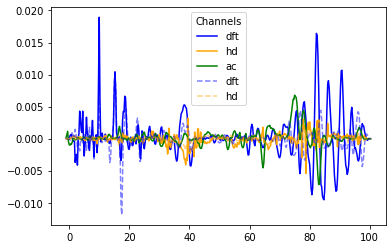

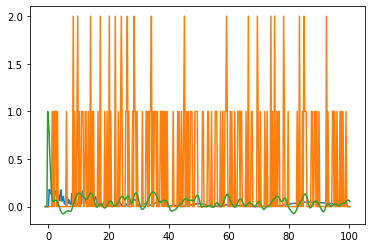

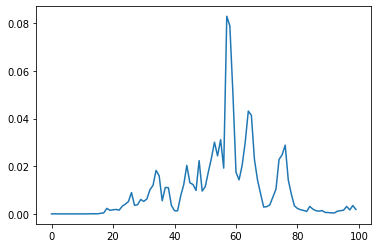

CoRoT ID: 102598868
Shap values (sorted): [[57 58 59 64 65 55 63 53 76 75]]
Logg from Hareter: [3.9]
Avg logg from NN: [4.35666142]
Confidence logg from NN: {'logg_min': array([4.08674386]), 'logg_max': array([4.62657899])}
Logg from Hareter is inside NN confidence=: [False]


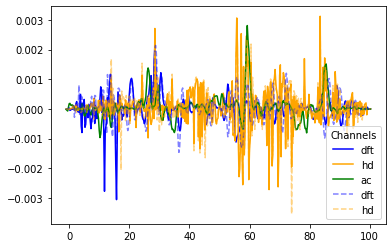

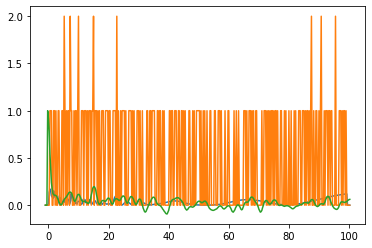

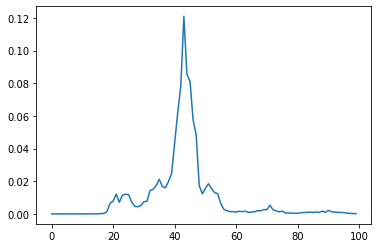

CoRoT ID: 102686153
Shap values (sorted): [[43 44 45 42 41 46 47 40 39 35]]
Logg from Hareter: [3.525]
Avg logg from NN: [4.19038353]
Confidence logg from NN: {'logg_min': array([3.92008153]), 'logg_max': array([4.46068552])}
Logg from Hareter is inside NN confidence=: [False]


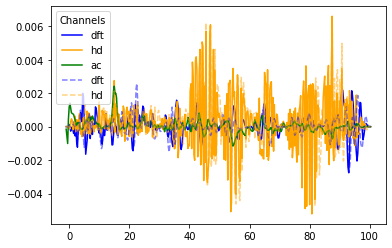

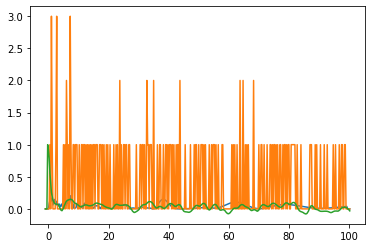

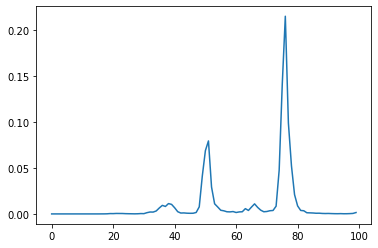

CoRoT ID: 102618519
Shap values (sorted): [[76 75 77 51 50 78 74 49 52 79]]
Logg from Hareter: [4.5]
Avg logg from NN: [4.52637184]
Confidence logg from NN: {'logg_min': array([4.25673973]), 'logg_max': array([4.79600395])}
Logg from Hareter is inside NN confidence=: [ True]


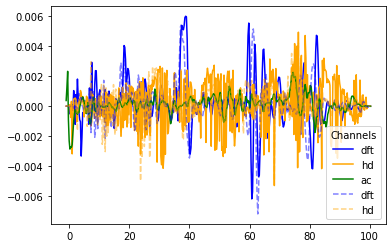

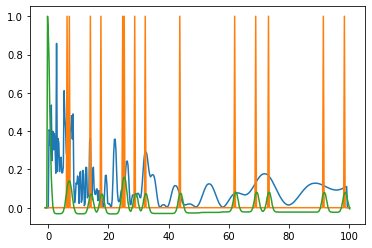

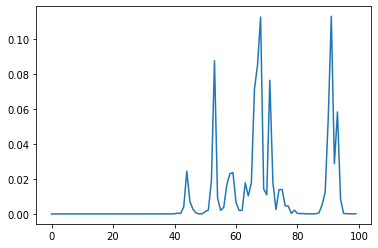

CoRoT ID: 102788412
Shap values (sorted): [[91 68 53 67 71 66 93 90 92 44]]
Logg from Hareter: [3.925]
Avg logg from NN: [4.63262869]
Confidence logg from NN: {'logg_min': array([4.36311825]), 'logg_max': array([4.90213913])}
Logg from Hareter is inside NN confidence=: [False]


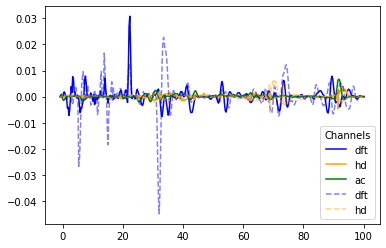

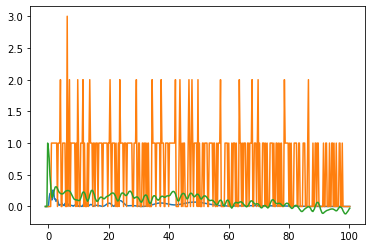

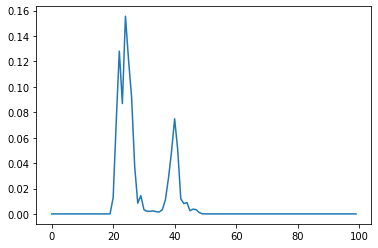

CoRoT ID: 102599598
Shap values (sorted): [[24 22 25 26 23 40 21 41 39 27]]
Logg from Hareter: [4.]
Avg logg from NN: [3.84633367]
Confidence logg from NN: {'logg_min': array([3.57493077]), 'logg_max': array([4.11773658])}
Logg from Hareter is inside NN confidence=: [ True]


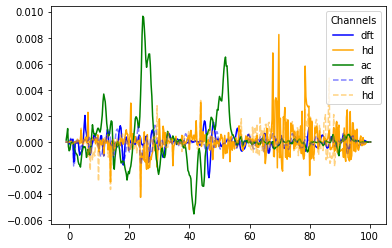

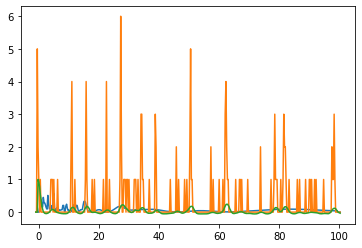

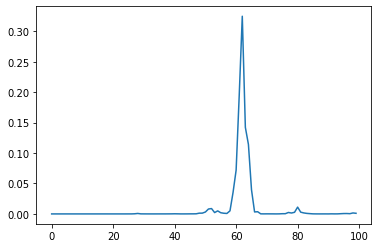

CoRoT ID: 102742700
Shap values (sorted): [[62 61 63 64 60 65 59 80 52 51]]
Logg from Hareter: [3.875]
Avg logg from NN: [4.4062648]
Confidence logg from NN: {'logg_min': array([4.13644207]), 'logg_max': array([4.67608754])}
Logg from Hareter is inside NN confidence=: [False]


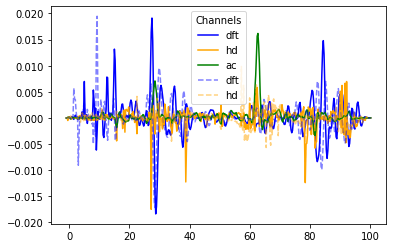

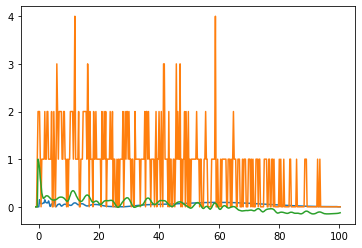

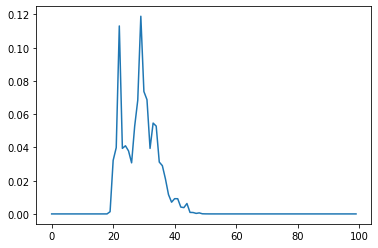

CoRoT ID: 102650434
Shap values (sorted): [[29 22 30 31 28 33 34 27 24 21]]
Logg from Hareter: [3.875]
Avg logg from NN: [3.9579878]
Confidence logg from NN: {'logg_min': array([3.68698512]), 'logg_max': array([4.22899048])}
Logg from Hareter is inside NN confidence=: [ True]


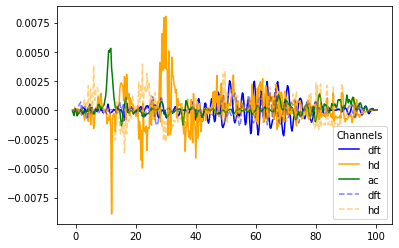

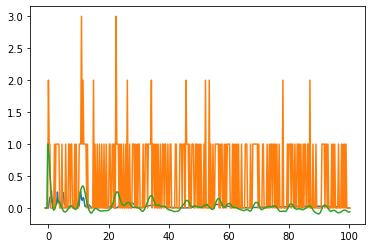

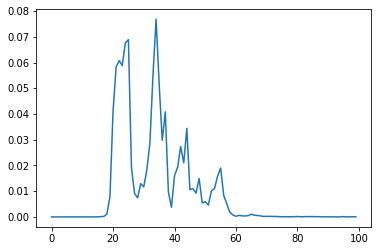

CoRoT ID: 102575808
Shap values (sorted): [[34 25 24 22 23 21 33 35 20 37]]
Logg from Hareter: [3.325]
Avg logg from NN: [4.05183454]
Confidence logg from NN: {'logg_min': array([3.7811369]), 'logg_max': array([4.32253217])}
Logg from Hareter is inside NN confidence=: [False]


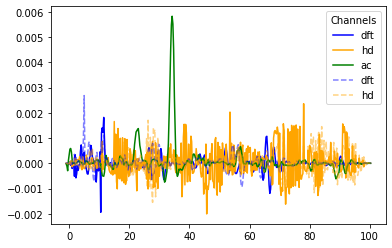

Counter({True: 32, False: 43})

In [12]:
# Read datasets of preprocessed stars
df_cor = corot()
dfcor = df_cor.load("../../astronn/data/corot/preprocessed/*.log", batch_size=1)

count = 0
aux = []
_x = []
_y = []
for star in dfcor.take(75):  # take the 75 corot stars
    # Star channels info
    x_star = star[1].numpy()
    # Star logg from data
    logg_data = star[2][0].numpy()
    # Dnu NN inference
    dnu_hat = sepconv_mod.predict_classes(star[1])
    
    # Calculate logg from Dnu infered by the NN
    rhos = getRhoFromDnu(dnu_hat, 4)
    radios = get_radio_from_rho(rhos["rho"], rhos["error"])
    loggs_condifence = get_logg_from_radio(radios["r_max"], radios["r_min"])
    # Get central point of logg confidence
    loggs_average = (loggs_condifence["logg_max"] + loggs_condifence["logg_min"]) / 2

    # Append data for posterior analysis
    _x.append(logg_data)
    _y.append(loggs_average)

    # Flag to point out if logg from data is inside the confidence interval
    flag = (
        logg_data <= loggs_condifence["logg_max"]
        and logg_data >= loggs_condifence["logg_min"]
    )
    aux.append(flag) # save

    # Plot graphs and info (debug)
    if True and count < 10:
        # Calculate gradient explainers and shap values
        e = shap.GradientExplainer(
            sepconv_mod, _train_shap, batch_size=10, local_smoothing=0
        )
        shap_values, indexes = e.shap_values(
            star[1].numpy(), nsamples=100, ranked_outputs=10
        )

        # Log info
        print("CoRoT ID:",star[0].numpy()[0].decode("utf-8"))
        print("Shap values (sorted):",indexes)
        print("Logg from Hareter:",logg_data)
        print("Avg logg from NN:",loggs_average)
        print("Confidence logg from NN:",loggs_condifence)
        print("Logg from Hareter is inside NN confidence=:",flag)

        # Plot star
        x = np.arange(-1, 100.5, 0.25)  # x axis from 0 to 100
        plt.plot(x, x_star[0, :, 0])
        plt.plot(x, x_star[0, :, 1])
        plt.plot(x, x_star[0, :, 2])
        plt.show()
        plt.plot(sepconv_mod.predict_proba(x_star)[0][0:100])
        plt.show()

        # Plot shap
        
        plt.plot(x, shap_values[0][0][:, [0]], label="dft", linestyle="solid", color="blue")
        plt.plot(
            x, shap_values[0][0][:, [1]], label="hd", linestyle="solid", color="orange"
        )
        plt.plot(x, shap_values[0][0][:, [2]], label="ac", linestyle="solid", color="green")
        plt.plot(
            x,
            shap_values[1][0][:, [0]],
            label="dft",
            linestyle="--",
            color="blue",
            alpha=0.5,
        )
        plt.plot(
            x,
            shap_values[1][0][:, [1]],
            label="hd",
            linestyle="--",
            color="orange",
            alpha=0.5,
        )
        ax2.plot(
            x,
            shap_values[1][0][:, [2]],
            label="ac",
            linestyle="--",
            color="green",
            alpha=0.5,
        )

        plt.legend(title="Channels")
        plt.show()
        print("\n")

    count += 1
# Compatible cases numbers
Counter([e[0] for e in aux])

### Error analysis

LinearGAM                                                                                                 
=============================================== ==========================================================
Distribution:                        NormalDist Effective DoF:                                      5.1114
Link Function:                     IdentityLink Log Likelihood:                                  -562.6575
Number of Samples:                           75 AIC:                                             1137.5378
                                                AICc:                                            1138.8182
                                                GCV:                                                0.0552
                                                Scale:                                              0.0485
                                                Pseudo R-Squared:                                   0.3249
Feature Function                  Lam

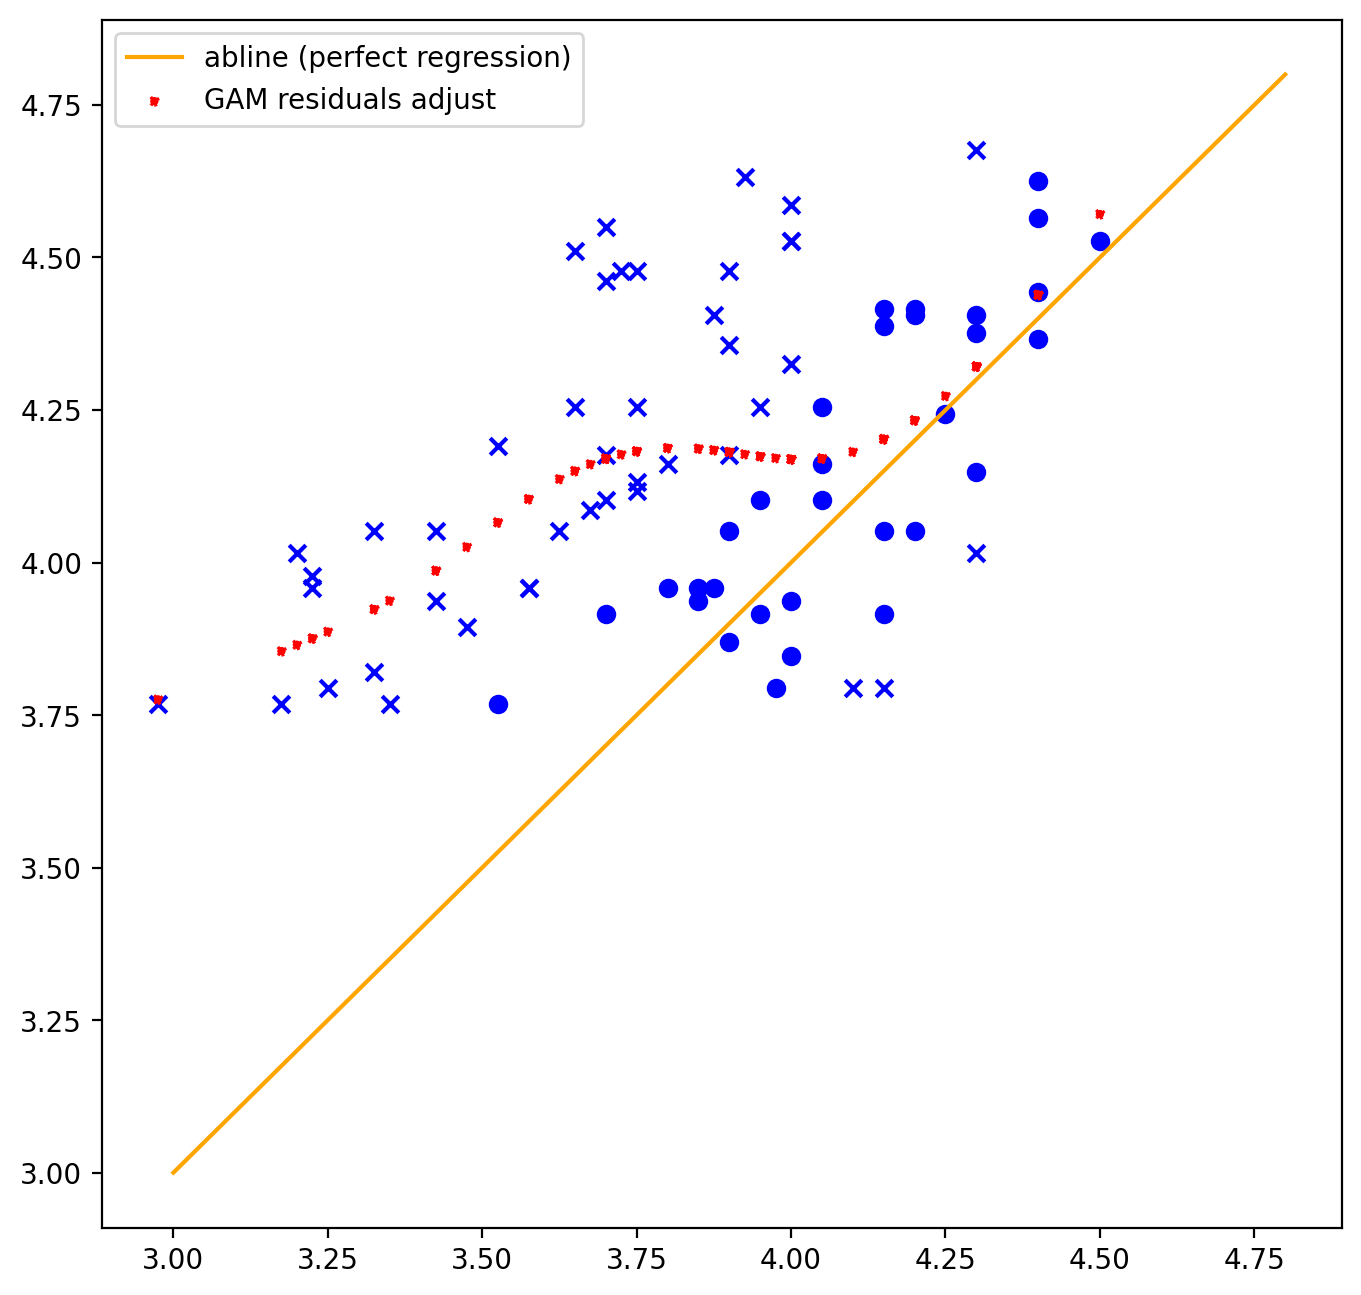

In [10]:
_x = np.concatenate(_x).ravel()
_y = np.concatenate(_y).ravel()
_aux = np.concatenate(aux).ravel()

# Fit non-lineal model on "residuals"
gam = LinearGAM(n_splines=10).fit(_x, _y)
gam.summary()

# Scatter all "residuals"
fig = plt.subplots(1, figsize=(8, 8), dpi=200)
for i in range(len(_x)):
    if _aux[i]:
        mark = "o"  # compatible
    else:
        mark = "x"  # no-compatible
    plt.scatter(_x[i], _y[i], marker=mark, color="blue")
# Plot model
plt.scatter(
    _x,
    gam.predict(_x),
    c="red",
    marker=".",
    linestyle=":",
    label="GAM residuals adjust",
)
# Add abline(0,1)
x = np.linspace(3.0, 4.8, 10)
plt.plot(x, x + 0, linestyle="solid", c="orange", label="abline (perfect regression)")
plt.legend(title="")
plt.show()